In [1]:
import glob
import pickle
import numpy
import tensorflow as tf
import music21 as m21
from music21 import converter, instrument, note, chord, stream, tempo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization as BatchNorm
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow.keras.regularizers as regularizers

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Aggregate notes in chords

For each track in the Nocturnes dataset, extract single notes with its duration and start time, and convert to chords

In [ ]:
!pip install pretty_midi

In [ ]:
import pretty_midi

In [ ]:
# SECONDA VERSIONE: AGGREGO SOLO QUELLE NOTE ESEGUITE NELLO STESSO MOMENTO
def aggregate_notes_2(notes_info_tmp):

    notes_processed = pd.DataFrame(columns=['pitch', 'duration', 'start_time'])  

    while(True):
        #print("Linee rimanenti da elaborare:", len(notes_info_tmp))
        nota_i_info = notes_info_tmp.iloc[0]
        original_start_time = nota_i_info.start_time
        target_start_time = nota_i_info.start_time
        durata_target = nota_i_info.duration
        lista_note_stesso_momento = [nota_i_info.pitch]
        indici_da_eliminare = [0]
        final_duration = durata_target


        for j in numpy.arange(1,len(notes_info_tmp)):

            #print("    Analizzo: ", notes_info_tmp.iloc[j].pitch,",", notes_info_tmp.iloc[j].duration, ",", notes_info_tmp.iloc[j].start_time)
            #if has same start time
            if notes_info_tmp.iloc[j].start_time == original_start_time and notes_info_tmp.iloc[j].duration == durata_target:
                #print("    Stesso start time")
                lista_note_stesso_momento.append(str(notes_info_tmp.iloc[j].pitch))
                indici_da_eliminare.append(j)
                final_duration = max(final_duration,notes_info_tmp.iloc[j].duration )

            #exit condition
            if notes_info_tmp.iloc[j].start_time > target_start_time:
                #print("    Esco")
                break

        #if the list has cardinality equal to one, it represents a note
        if len(lista_note_stesso_momento) == 1:
            notes_processed = notes_processed.append({'pitch': str(lista_note_stesso_momento[0]), 'duration': durata_target, 'start_time': original_start_time}, ignore_index=True)
        #otherwise is a chord
        else:
            chord_ = '.'.join(sorted(set(lista_note_stesso_momento)))
            notes_processed = notes_processed.append({'pitch': chord_, 'duration': (target_start_time-original_start_time+durata_target), 'start_time': original_start_time}, ignore_index=True)
        #I delete lines that have been processed.
        notes_info_tmp.drop(indici_da_eliminare, axis=0, inplace=True)
        notes_info_tmp.reset_index(inplace = True, drop = True)
        
        #clear the list
        lista_note_stesso_momento.clear()

        if len(notes_info_tmp)==0:
            break
    
    return notes_processed

In [ ]:
notes = pd.DataFrame(columns=['pitch', 'duration', 'offset'])  
indexes_new_composition = []

i = 1

for file in glob.glob("../../midi-dataset//Nocturnes/*.mid"):
    
    print("Parsing ",i,"° file: ", file)
    
    midi_data = pretty_midi.PrettyMIDI(file)

    notes_info = pd.DataFrame(columns=['pitch', 'duration', 'start_time'])  

    for instrument in midi_data.instruments:
        for note in instrument.notes:
            #print("name: ", pretty_midi.note_number_to_name(note.pitch), "   duration:", note.duration, "   start:", note.start,"    end:", note.end, "    velocity:", note.velocity)
            notes_info = notes_info.append({'pitch':  pretty_midi.note_number_to_name(note.pitch), 'duration': round(note.duration,1), 'start_time': round(note.start,2)}, ignore_index=True)

    notes_info = notes_info.sort_values(by=['start_time'])

    notes_processed = aggregate_notes_2(notes_info)

    #to avoid too short durations, I delete them
    threshold_duration = 0.08

    notes_processed.drop(notes_processed[notes_processed['duration'] <= threshold_duration].index, inplace = True)

    #I indicate the start time in terms of "offset" from the previous one
    notes_final = pd.DataFrame(columns=['pitch', 'duration', 'offset'])  

    prev_offset = 0
    for row in numpy.arange(len(notes_processed)):
        notes_final = notes_final.append({'pitch': notes_processed.iloc[row].pitch, 'duration': round(notes_processed.iloc[row].duration, 2), 'offset': round(notes_processed.iloc[row].start_time - prev_offset, 3)}, ignore_index=True)
        prev_offset = notes_processed.iloc[row].start_time
    
    indexes_new_composition.append(len(notes_final))
    notes = notes.append(notes_final, ignore_index=True)
    i=i+1

Parsing  1 ° file:  ../../midi-dataset//Nocturnes\50654a_nocturne_op_15_no_2_(nc)smythe.mid
Parsing  2 ° file:  ../../midi-dataset//Nocturnes\53627a_nocturne_op_62_no_2_e_major_(nc)smythe.mid
Parsing  3 ° file:  ../../midi-dataset//Nocturnes\58486a_nocturne_op_55_no_1_(nc)smythe.mid
Parsing  4 ° file:  ../../midi-dataset//Nocturnes\64833a_nocturne_op_32_no_1_b_major_(nc)smythe.mid
Parsing  5 ° file:  ../../midi-dataset//Nocturnes\nocturne_15_3_(c)unknown.mid
Parsing  6 ° file:  ../../midi-dataset//Nocturnes\nocturne_27_1_(c)inoue.mid
Parsing  7 ° file:  ../../midi-dataset//Nocturnes\nocturne_27_2_(c)inoue.mid
Parsing  8 ° file:  ../../midi-dataset//Nocturnes\nocturne_32_2_(c)unknown.mid
Parsing  9 ° file:  ../../midi-dataset//Nocturnes\nocturne_37_1_(c)unknown.mid
Parsing  10 ° file:  ../../midi-dataset//Nocturnes\nocturne_37_2_(c)unknown.mid
Parsing  11 ° file:  ../../midi-dataset//Nocturnes\nocturne_48_1_(c)unknown.mid
Parsing  12 ° file:  ../../midi-dataset//Nocturnes\nocturne_48_2_

Save dataframe (the dataframe contains the overall notes and chords of all the songs) and the index (in the dataframe) where a new composition is starting

In [ ]:
#save dataframe locally for fasting loading
notes.to_pickle("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/nocturnes - aggregation//notes_nocturnes.pkl")
a =(numpy.array(indexes_new_composition))
numpy.save("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/nocturnes - aggregation//indexes_new_composition_nocturnes",a)

In [28]:
#load dataframe
notes = pd.read_pickle("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/nocturnes - aggregation//notes_nocturnes.pkl")
indexes_new_composition = numpy.load("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/nocturnes - aggregation//indexes_new_composition_nocturnes.npy")

In [29]:
notes

,pitch,duration,offset
0,A#4,1.7,0.56
1,B4,0.4,1.70
2,C#2,4.6,0.22
3,A#4,0.7,0.17
4,G#4,0.5,0.63
...,...,...,...
22595,F2,4.3,0.17
22596,A#2,4.1,0.17
22597,A#3.D4,1.8,0.10
22598,D3,1.8,0.01


In [30]:
pitches = notes['pitch'].values
durations = notes['duration'].values
offset = notes['offset'].values

In [31]:
#get all pitch names
pitchnames = sorted(set(item for item in pitches))

# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

In [32]:
n_vocabs = len(set(pitches))  #vocabulary

max_duration = max(durations)
min_duration = min(durations)

max_offset = max(offset)
min_offset = min(offset)

In [33]:
n_vocabs

1460

# Creation of the sequences

In [34]:
#normalization
def min_max_normalization(x, minimum, maximum):
    return (x-minimum)/(maximum-minimum)

#used only for pitch
def min_max_denormalization(x, minimum, maximum):
    return int((x*(maximum-minimum)+minimum))

#used only for duration and offset
def min_max_denormalization_2(x, minimum, maximum):
    return ((x*(maximum-minimum)+minimum))

#transform each note/chord in its integer rapresentation
notes['pitch'] = notes['pitch'].map(lambda p: min_max_normalization(note_to_int[p], 0, n_vocabs))
#durations
notes['duration'] = notes['duration'].map(lambda d: min_max_normalization(d, min_duration, max_duration))
#offsets
notes['offset'] = notes['offset'].map(lambda o: min_max_normalization(o, min_offset, max_offset))

In [35]:

main_fields = ['pitch', 'duration', 'offset']
train_notes = numpy.stack([notes[field] for field in main_fields], axis=1)

train_notes

array([[1.14383562e-01, 9.30232558e-02, 4.20105026e-02],
       [4.32876712e-01, 1.74418605e-02, 1.27531883e-01],
       [5.01369863e-01, 2.61627907e-01, 1.65041260e-02],
       ...,
       [9.38356164e-02, 9.88372093e-02, 7.50187547e-03],
       [8.45205479e-01, 9.88372093e-02, 7.50187547e-04],
       [9.53424658e-01, 9.88372093e-02, 7.50187547e-04]])

In [36]:
len(train_notes)

22600

In [37]:
indexes_new_composition

array([1127, 1380, 1292, 1104,  529, 1245, 1505, 1570, 1014, 1267, 1117,
       1674, 1343, 1029, 2082,  753,  914, 1655], dtype=int32)

In [38]:
#seq_length = min(indexes_new_composition)
seq_length = 500

In [39]:
#per evitare di creare sequenze che appartengono ad entrambe le composizioni, splitto le train_notes, applico a ciascuna la funzione window, e poi concateno tutti i risultati
#in questo modo ogni sequenza appartiene alla propria composizione


final_train_dataset = tf.data.Dataset.from_tensor_slices(train_notes[0:indexes_new_composition[0]])
final_dataset_of_training_datasets = final_train_dataset.window(seq_length+1, shift=1, stride=1,drop_remainder=True)


#concateno tutte le altre sequenze
for index in numpy.arange(len(indexes_new_composition)):
    print("indice: ", index, " di valore ",indexes_new_composition[index])
    if indexes_new_composition[index] == indexes_new_composition[len(indexes_new_composition)-1]:
        break
    train_notes_i = train_notes[indexes_new_composition[index]:(indexes_new_composition[index] + indexes_new_composition[index+1]),:]
    train_dataset_i = tf.data.Dataset.from_tensor_slices(train_notes_i)
    dataset_of_training_datasets_i = train_dataset_i.window(seq_length+1, shift=1, stride=1,drop_remainder=True)
    print("  ",len(train_dataset_i), "  ",len(dataset_of_training_datasets_i))
    final_dataset_of_training_datasets = final_dataset_of_training_datasets.concatenate(dataset_of_training_datasets_i)


indice:  0  di valore  1127
   1380    880
indice:  1  di valore  1380
   1292    792
indice:  2  di valore  1292
   1104    604
indice:  3  di valore  1104
   529    29
indice:  4  di valore  529
   1245    745
indice:  5  di valore  1245
   1505    1005
indice:  6  di valore  1505
   1570    1070
indice:  7  di valore  1570
   1014    514
indice:  8  di valore  1014
   1267    767
indice:  9  di valore  1267
   1117    617
indice:  10  di valore  1117
   1674    1174
indice:  11  di valore  1674
   1343    843
indice:  12  di valore  1343
   1029    529
indice:  13  di valore  1029
   2082    1582
indice:  14  di valore  2082
   753    253
indice:  15  di valore  753
   914    414
indice:  16  di valore  914
   1655    1155
indice:  17  di valore  1655


In [ ]:
len(list(final_dataset_of_training_datasets))

13600

In [40]:
flatten = lambda x: x.batch(seq_length+1, drop_remainder=True)

training_sequences = final_dataset_of_training_datasets.flat_map(flatten)


# Models and trainining

In [18]:
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, Dropout, ReLU, Softmax
from tensorflow.keras import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

## Model 1: predict next note

In [ ]:
def create_ground_truth_and_preprocess_sequence(sequence, n_vocabs):
    print(sequence)
    #I get all the items in the batch except the last one
    input = sequence[:-1]
    #take the last element and use it as ground truth
    grt = sequence[-1]

    #denormalize it
    grt_denormalized = min_max_denormalization(grt[0], 0, n_vocabs)

    #create a one-hot encoding
    label = tf.one_hot(grt_denormalized, n_vocabs)
    return input, label

dataset_of_training_sequences = training_sequences.map(lambda s: create_ground_truth_and_preprocess_sequence(s, n_vocabs),  num_parallel_calls=tf.data.experimental.AUTOTUNE)

Tensor("args_0:0", shape=(501, 3), dtype=float64)


In [ ]:
for seq, target in dataset_of_training_sequences.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 3):', seq[0: 3])
  print()
  print('target:', target)

sequence shape: (500, 3)
sequence elements (first 3): tf.Tensor(
[[0.11438356 0.09302326 0.0420105 ]
 [0.43287671 0.01744186 0.12753188]
 [0.50136986 0.26162791 0.01650413]], shape=(3, 3), dtype=float64)

target: tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(1460,), dtype=float32)


In [ ]:
batch_size = 64
training_buffer_size = len(notes)- seq_length  # the number of items in the training dataset

training_dataset = (dataset_of_training_sequences
                        .batch(batch_size, drop_remainder=True)
                        .cache()
                        .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
#using functional API...
input_shape = (seq_length, 3)

#core of the model
inputs = Input(input_shape)
lstm_last_state = LSTM(int(n_vocabs*0.3), return_sequences=True)(inputs)

lstm_last_state = LSTM(int(n_vocabs*0.4), return_sequences=True)(lstm_last_state)

lstm_last_state = LSTM(int(n_vocabs*0.5))(lstm_last_state)

dense = Dense(int(n_vocabs*0.6))(lstm_last_state)

#Outputs of the model
pitch_output = Dense(n_vocabs,activation='softmax')(dense)

pitch_predictor = Model(inputs, outputs=pitch_output)

In [ ]:

optimizer = Adam(learning_rate=0.0001)

#carico precedenti pesi
pitch_predictor.load_weights("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/models/nocturnes_pitch_predictor_500.hdf5")

pitch_predictor.compile(loss="categorical_crossentropy",  optimizer=optimizer, metrics=['accuracy'])

pitch_predictor.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 3)]          0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 438)          774384    
                                                                 
 lstm_4 (LSTM)               (None, 100, 584)          2389728   
                                                                 
 lstm_5 (LSTM)               (None, 730)               3839800   
                                                                 
 dense_2 (Dense)             (None, 876)               640356    
                                                                 
 dense_3 (Dense)             (None, 1460)              1280420   
                                                                 
Total params: 8,924,688
Trainable params: 8,924,688
Non-tra

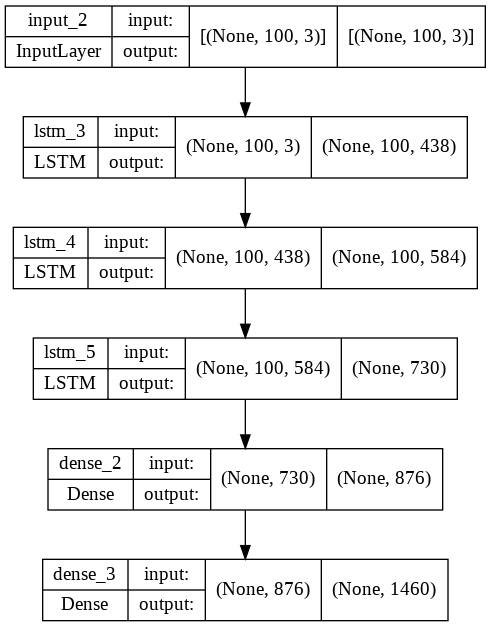

In [ ]:
plot_model(pitch_predictor, show_shapes=True, show_layer_names=True)

In [ ]:
filepath = "/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/models/nocturnes_pitch_predictor_500.hdf5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='accuracy',
    verbose=0,
    save_best_only=True,
    mode='max'
)

callbacks = [checkpoint]

epochs = 100

history = pitch_predictor.fit(training_dataset,epochs=epochs,callbacks=callbacks, verbose=1, shuffle=True)

Epoch 1/100
254/254 [==============================] - 101s 381ms/step - loss: 4.8381 - accuracy: 0.0332
Epoch 2/100
254/254 [==============================] - 97s 380ms/step - loss: 4.4343 - accuracy: 0.0343
Epoch 3/100
254/254 [==============================] - 95s 376ms/step - loss: 4.3896 - accuracy: 0.0373
Epoch 4/100
254/254 [==============================] - 95s 374ms/step - loss: 4.3701 - accuracy: 0.0364
Epoch 5/100
254/254 [==============================] - 95s 376ms/step - loss: 4.3551 - accuracy: 0.0397
Epoch 6/100
254/254 [==============================] - 95s 374ms/step - loss: 4.3490 - accuracy: 0.0386
Epoch 7/100
254/254 [==============================] - 95s 373ms/step - loss: 4.3392 - accuracy: 0.0386
Epoch 8/100
254/254 [==============================] - 96s 380ms/step - loss: 4.3341 - accuracy: 0.0398
Epoch 9/100
254/254 [==============================] - 95s 375ms/step - loss: 4.3335 - accuracy: 0.0383
Epoch 10/100
254/254 [==============================] - 96s 378

KeyboardInterrupt: ignored

In [ ]:
df = pd.DataFrame(history.history)

In [ ]:
df.to_pickle("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/training_results/training_pitch_500_1.pkl")

Loading (for documentation) the training results when using sequences of 100

In [ ]:
#load training info for sequences of 100 elements 
df1 = pd.read_pickle("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/training_results/training_1.pkl")
df2 = pd.read_pickle("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/training_results/training_2.pkl")

df_100 = df1.append(df2, ignore_index=True)

In [ ]:
#max accuracy achived
max_accuracy_with_100 = df_100['accuracy'].max()

#min loss achived
min_loss_with_100 = df_100['loss'].min()

print("max accuracy achived", max_accuracy_with_100)
print("min loss achived", min_loss_with_100)

max accuracy achived 0.9996634721755981
min loss achived 0.0032432633452117443


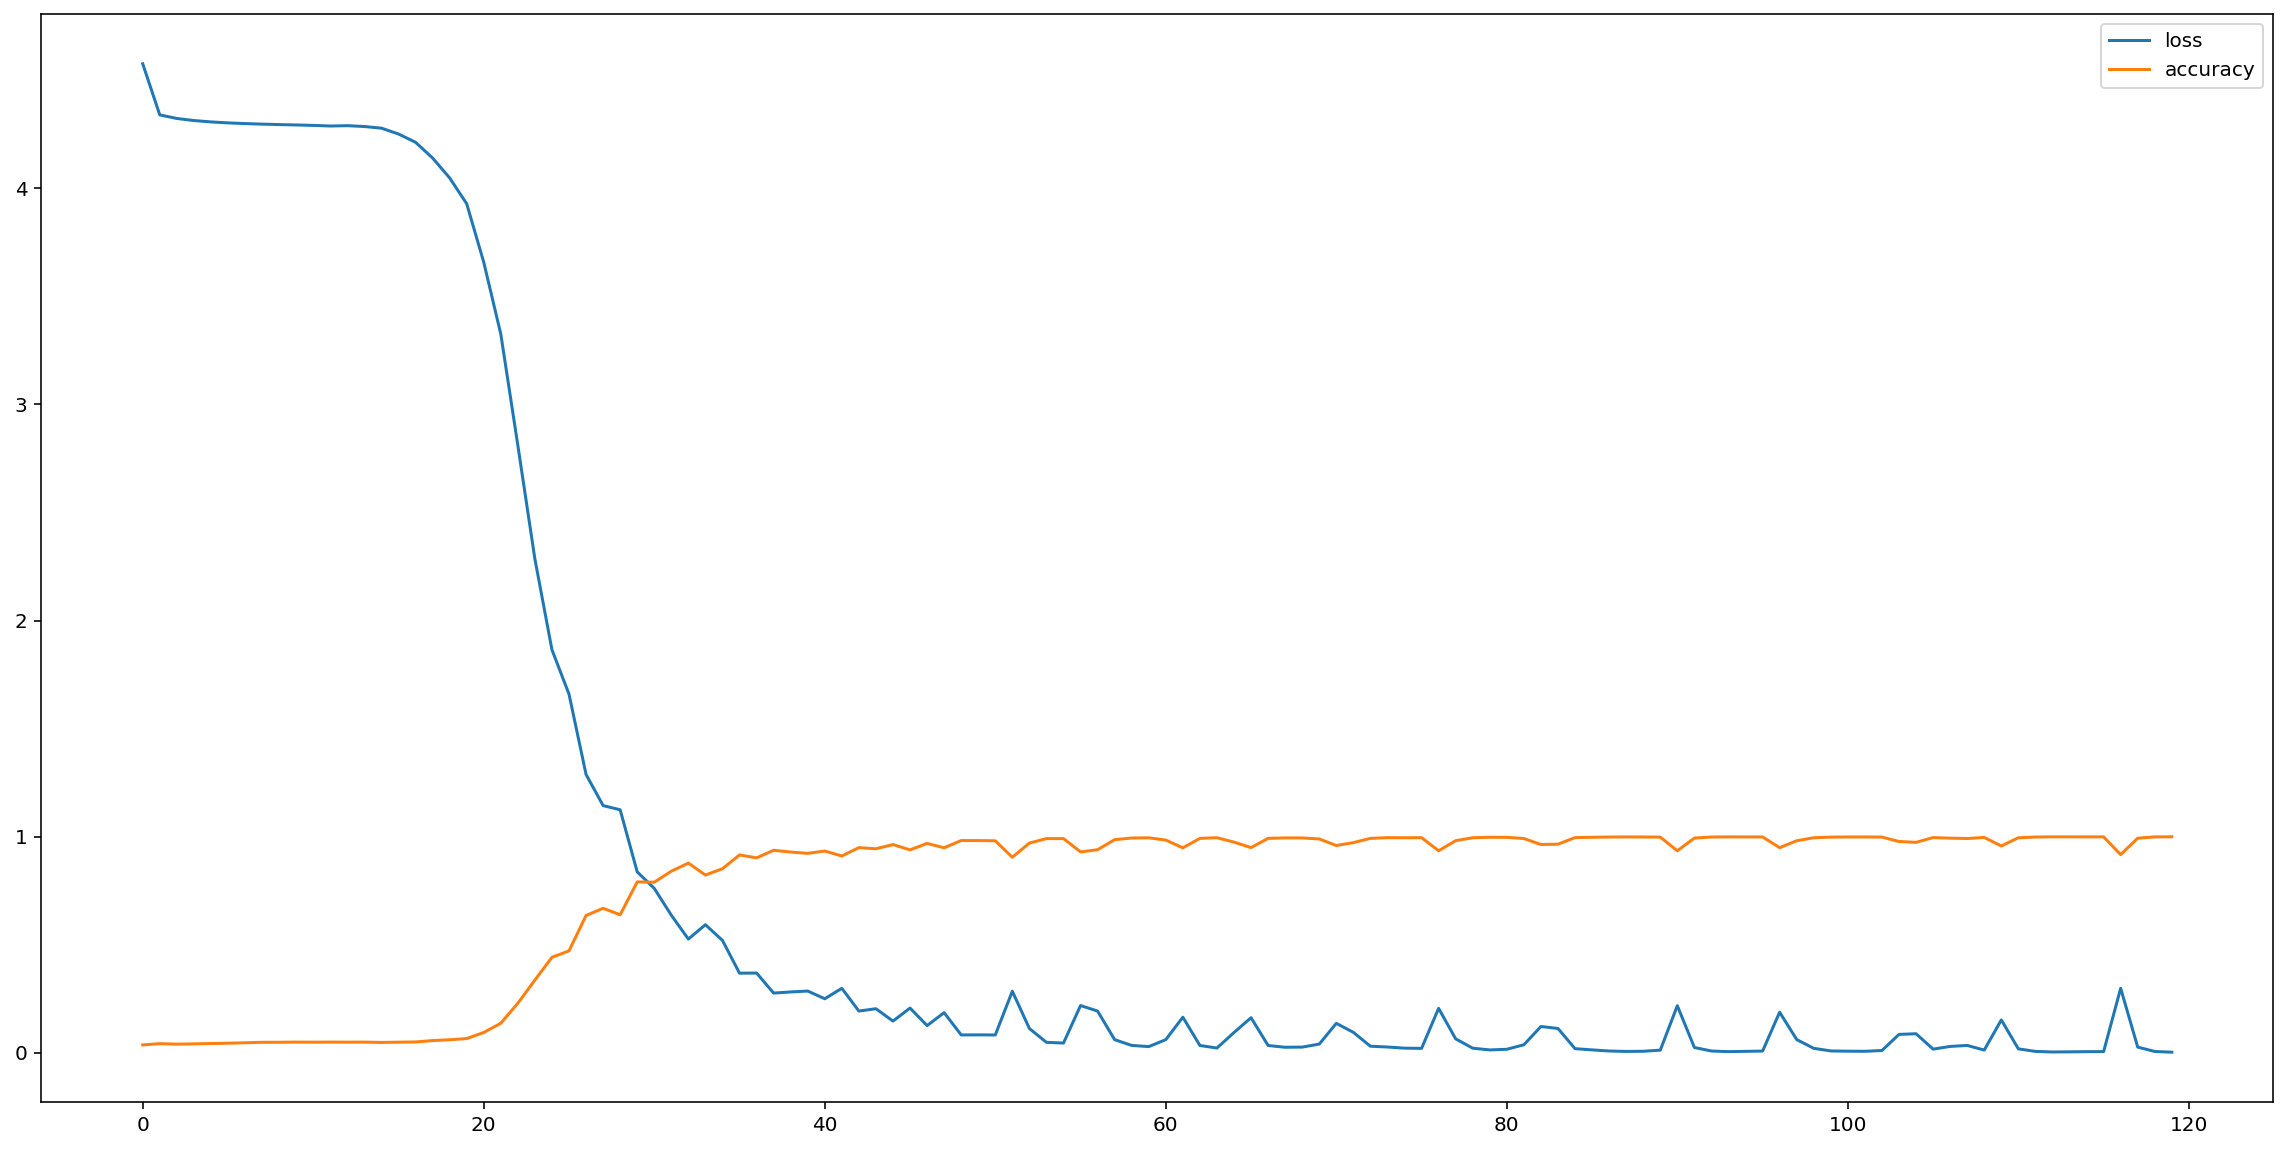

In [ ]:
df_100.plot(figsize=(20,10))

Loading (for documentation) the training results when using sequences of 500

In [ ]:
#load training info for sequences of 100 elements 
df_100 = pd.read_pickle("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/training_results/training_pitch_500_1.pkl")


In [ ]:
#max accuracy achived
max_accuracy_with_100 = df_100['accuracy'].max()

#min loss achived
min_loss_with_100 = df_100['loss'].min()

print("max accuracy achived", max_accuracy_with_100)
print("min loss achived", min_loss_with_100)

max accuracy achived 0.9976415038108826
min loss achived 0.013464250601828098


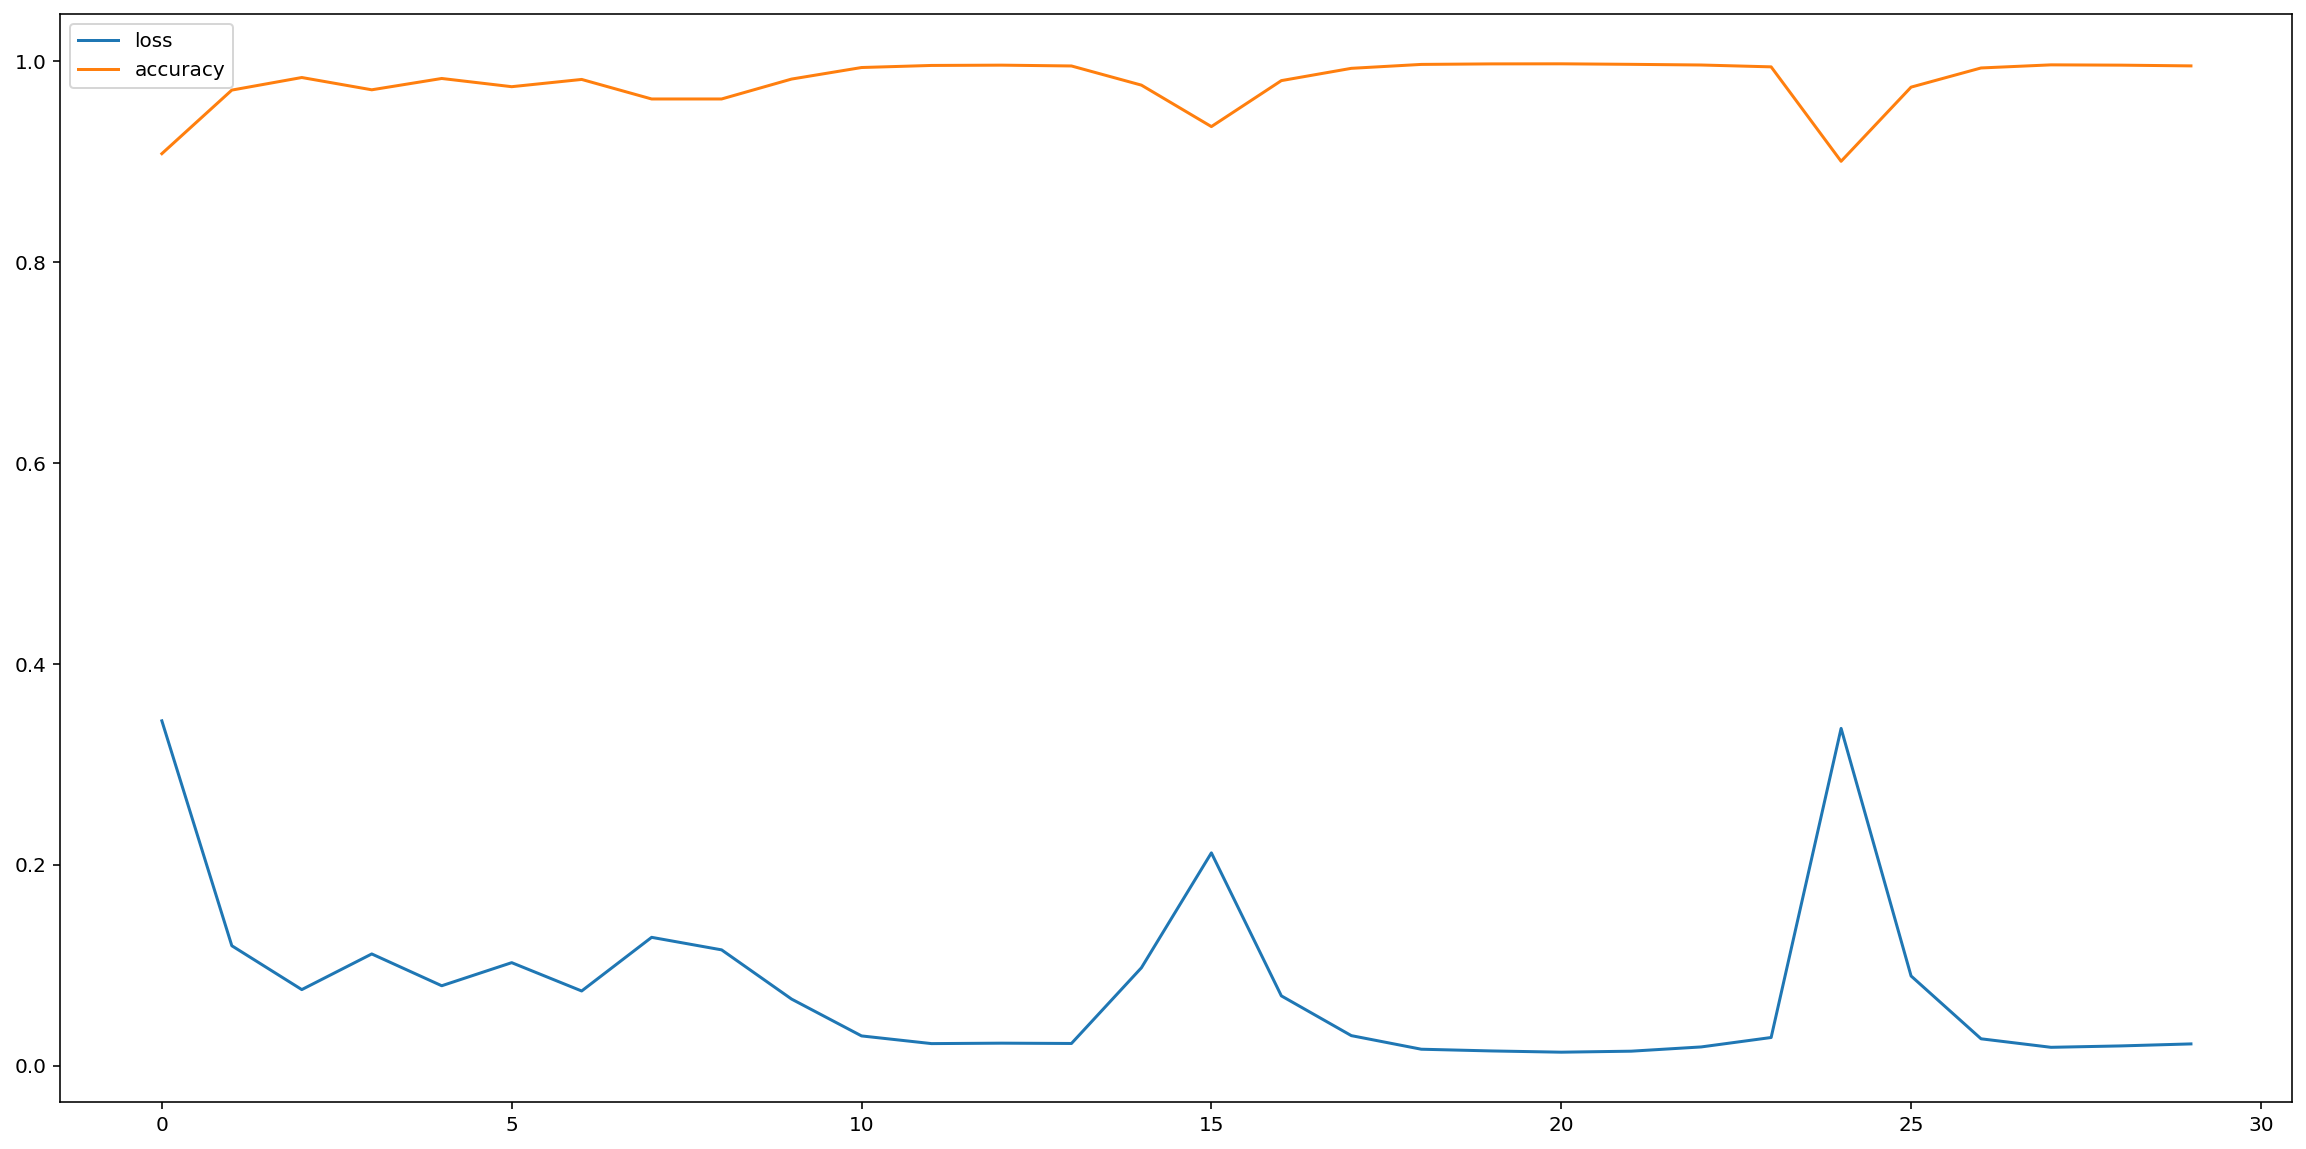

In [ ]:
df_100.plot(figsize=(20,10))

## Predict next duration

In [41]:
def create_ground_truth_and_preprocess_sequence(sequence, min_duration, max_duration):
    print(sequence)
    #prendo tutti gli elementi del batch tranne l'ultimo
    input = sequence[:-1]
    #prendo l'ultimo elemento e lo utilizzo come groudn truth
    grt = sequence[-1]
 
    label = min_max_denormalization_2(grt[1], min_duration, max_duration)

    return input, label

dataset_of_training_sequences = training_sequences.map(lambda s: create_ground_truth_and_preprocess_sequence(s, min_duration, max_duration),  num_parallel_calls=tf.data.experimental.AUTOTUNE)

Tensor("args_0:0", shape=(501, 3), dtype=float64)


In [42]:
for seq, target in dataset_of_training_sequences.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 3):', seq[0: 3])
  print()
  print('target:', target)

sequence shape: (500, 3)
sequence elements (first 3): tf.Tensor(
[[0.11438356 0.09302326 0.0420105 ]
 [0.43287671 0.01744186 0.12753188]
 [0.50136986 0.26162791 0.01650413]], shape=(3, 3), dtype=float64)

target: tf.Tensor(0.8, shape=(), dtype=float64)


In [43]:
batch_size = 128
training_buffer_size = len(notes)- seq_length  # the number of items in the training dataset

training_dataset = (dataset_of_training_sequences
                        .batch(batch_size, drop_remainder=True)
                        .cache()
                        .prefetch(tf.data.experimental.AUTOTUNE))

In [44]:
#using functional API...
input_shape = (seq_length, 3)

#core of the model
inputs = Input(input_shape)
lstm_last_state = LSTM(int(n_vocabs*0.15), return_sequences=True)(inputs)
lstm_last_state = LSTM(int(n_vocabs*0.18), return_sequences=True)(lstm_last_state)
lstm_last_state = LSTM(int(n_vocabs*0.2))(lstm_last_state)

dense = Dense(int(n_vocabs*0.25))(lstm_last_state)

duration_output = Dense(1, activation="relu")(dense)

duration_predictor = Model(inputs, outputs=duration_output)

In [45]:

optimizer = Adam(learning_rate=0.00001)

#carico precedenti pesi
duration_predictor.load_weights("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/models/nocturnes_duration_predictor_500_3.hdf5")

duration_predictor.compile(loss="mean_squared_error",  optimizer=optimizer, metrics=['mean_squared_error'])

duration_predictor.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500, 3)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 500, 219)          195348    
                                                                 
 lstm_7 (LSTM)               (None, 500, 262)          505136    
                                                                 
 lstm_8 (LSTM)               (None, 292)               648240    
                                                                 
 dense_4 (Dense)             (None, 365)               106945    
                                                                 
 dense_5 (Dense)             (None, 1)                 366       
                                                                 
Total params: 1,456,035
Trainable params: 1,456,035
Non-tra

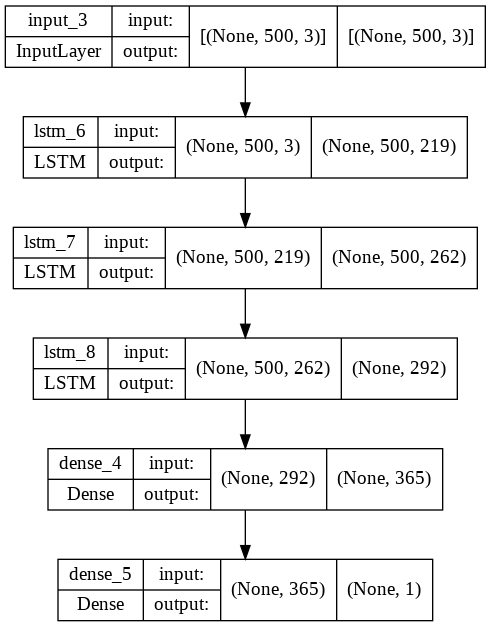

In [46]:
plot_model(duration_predictor, show_shapes=True, show_layer_names=True)

In [ ]:
filepath = "/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/models/nocturnes_duration_predictor_500_3.hdf5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='mean_squared_error',
    verbose=0,
    save_best_only=True,
    mode='min'
)

callbacks = [checkpoint]

epochs = 40
history = duration_predictor.fit(training_dataset,epochs=epochs,callbacks=callbacks, verbose=1, shuffle=True)

Epoch 1/40
106/106 [==============================] - 29s 249ms/step - loss: 3.5487e-04 - mean_squared_error: 3.5487e-04
Epoch 2/40
106/106 [==============================] - 27s 251ms/step - loss: 3.5208e-04 - mean_squared_error: 3.5208e-04
Epoch 3/40
106/106 [==============================] - 26s 245ms/step - loss: 3.6858e-04 - mean_squared_error: 3.6858e-04
Epoch 4/40
106/106 [==============================] - 27s 251ms/step - loss: 3.7755e-04 - mean_squared_error: 3.7755e-04
Epoch 5/40
106/106 [==============================] - 26s 245ms/step - loss: 3.5346e-04 - mean_squared_error: 3.5346e-04
Epoch 6/40
106/106 [==============================] - 27s 254ms/step - loss: 3.5062e-04 - mean_squared_error: 3.5062e-04
Epoch 7/40
106/106 [==============================] - 26s 249ms/step - loss: 3.4032e-04 - mean_squared_error: 3.4032e-04
Epoch 8/40
106/106 [==============================] - 26s 245ms/step - loss: 3.6329e-04 - mean_squared_error: 3.6329e-04
Epoch 9/40
106/106 [============

In [ ]:
df = pd.DataFrame(history.history)

In [ ]:
df.to_pickle("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/training_results/training_duration_500_3.pkl")

In [ ]:
df = pd.read_pickle("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/training_results/training_duration_500_3.pkl")

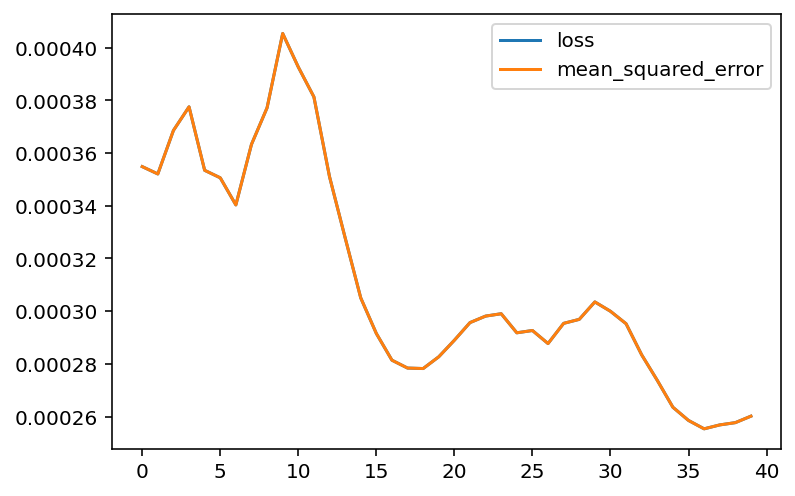

In [ ]:
df.plot()

Loading (for documentation) the training results when using sequences of 100

In [ ]:
#load training info for sequences of 100 elements 
df1 = pd.read_pickle("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/training_results/training_duration_1.pkl")
df2 = pd.read_pickle("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/training_results/training_duration_2.pkl")
df3 = pd.read_pickle("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/training_results/training_duration_3.pkl")

df_100 = df1.append(df2, ignore_index=True)
df_100 = df_100.append(df3, ignore_index=True)

In [ ]:

#min loss achived
min_loss_with_100 = df_100['loss'].min()

print("min loss achived", min_loss_with_100)

min loss achived 0.0006335412617772818


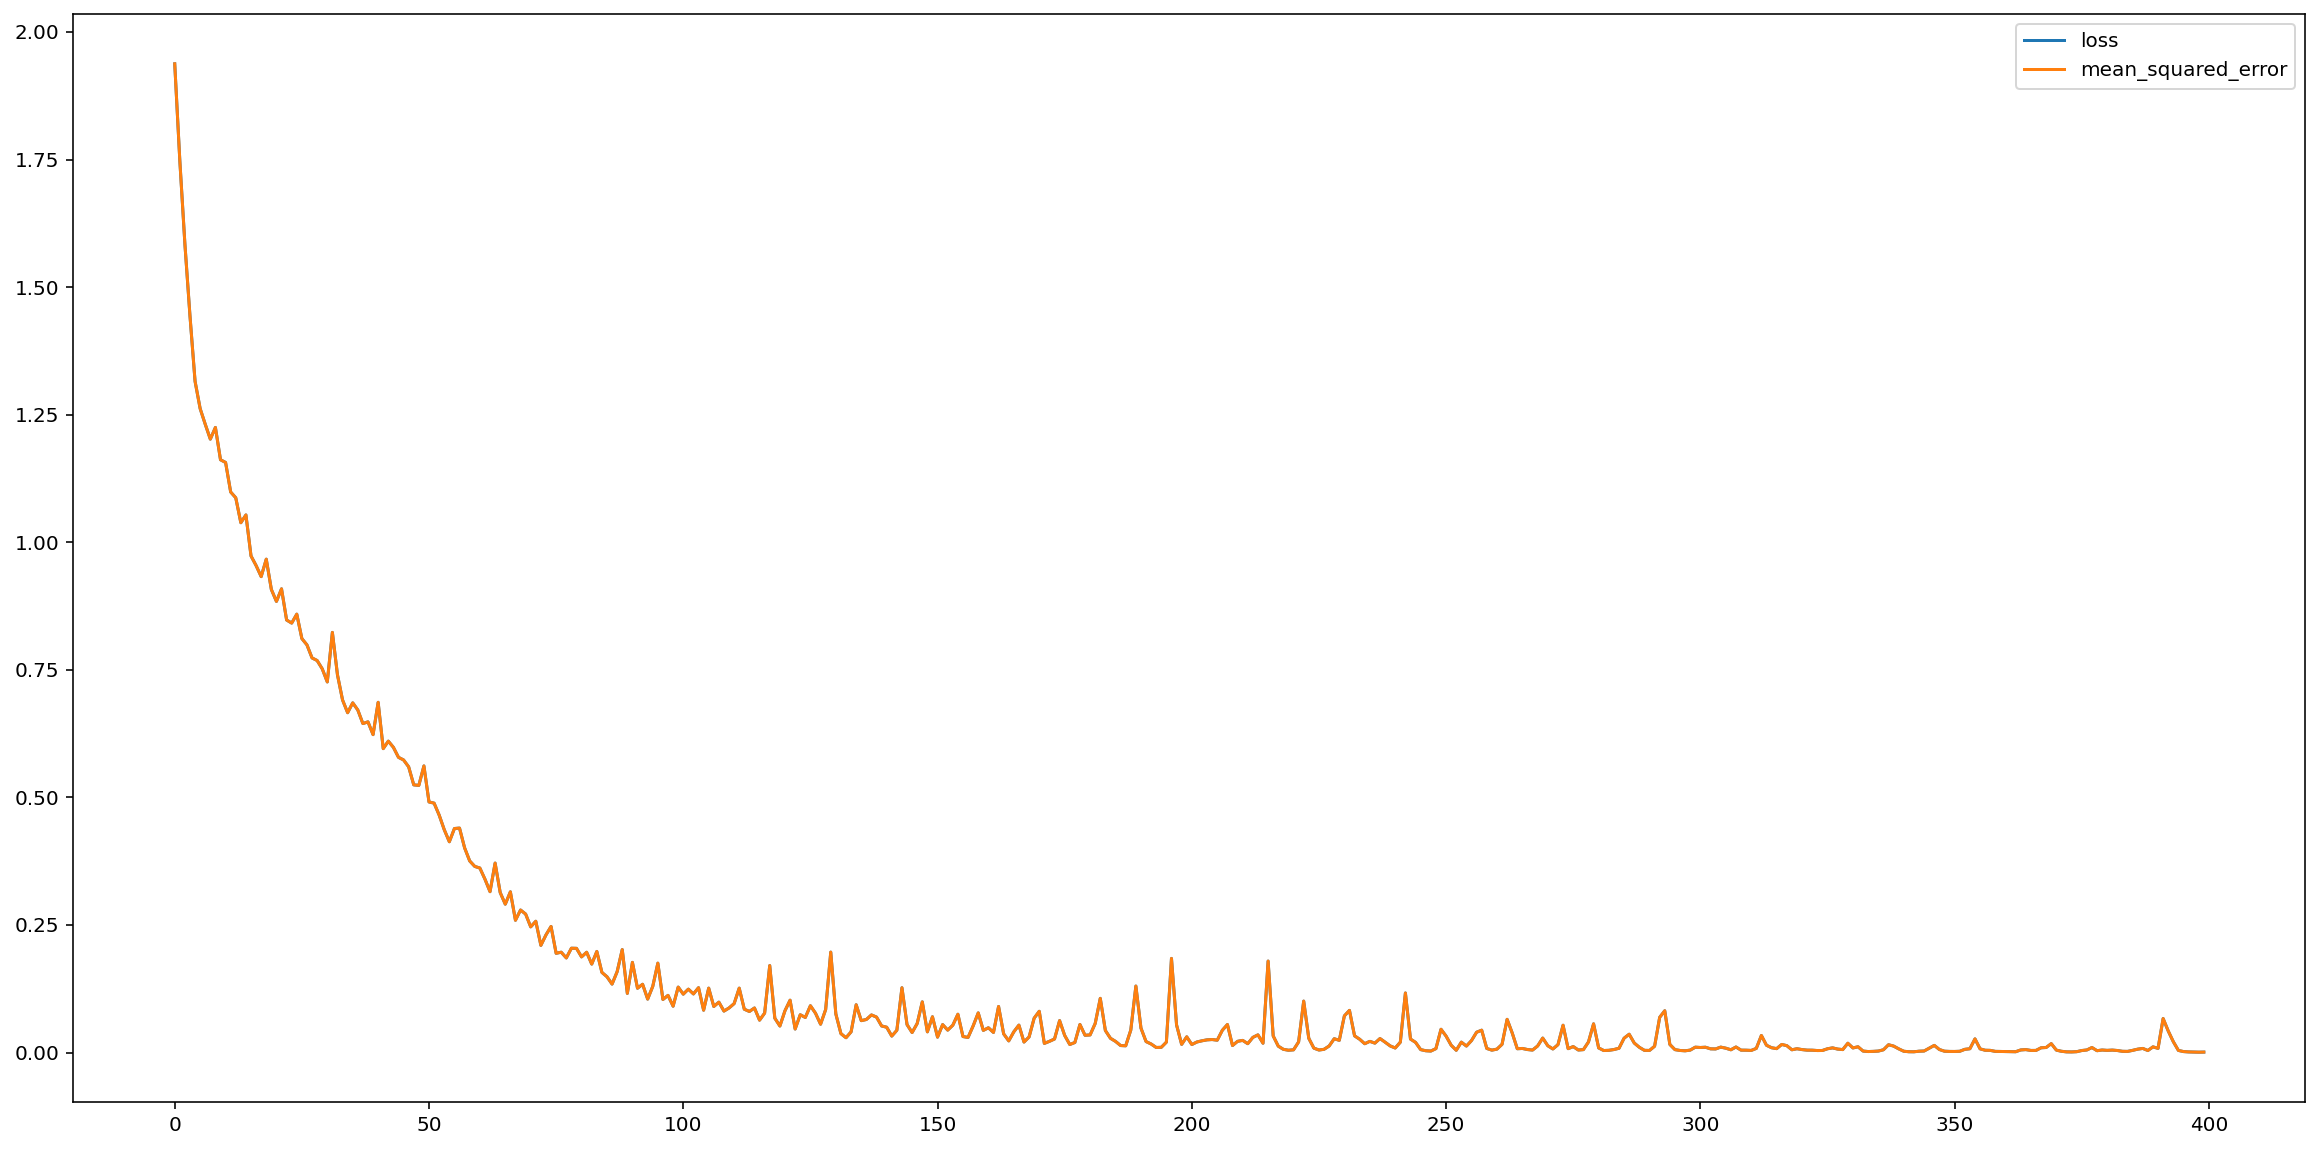

In [ ]:
df_100.plot(figsize=(20,10))

Loading (for documentation) the training results when using sequences of 500

In [ ]:
#load training info for sequences of 100 elements 
df1 = pd.read_pickle("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/training_results/training_duration_500_1.pkl")
df2 = pd.read_pickle("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/training_results/training_duration_500_2.pkl")
df3 = pd.read_pickle("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/training_results/training_duration_500_3.pkl")

df_100 = df1.append(df2, ignore_index=True)
df_100 = df_100.append(df3, ignore_index=True)

In [ ]:

#min loss achived
min_loss_with_100 = df_100['loss'].min()

print("min loss achived", min_loss_with_100)

min loss achived 0.0002553592494223267


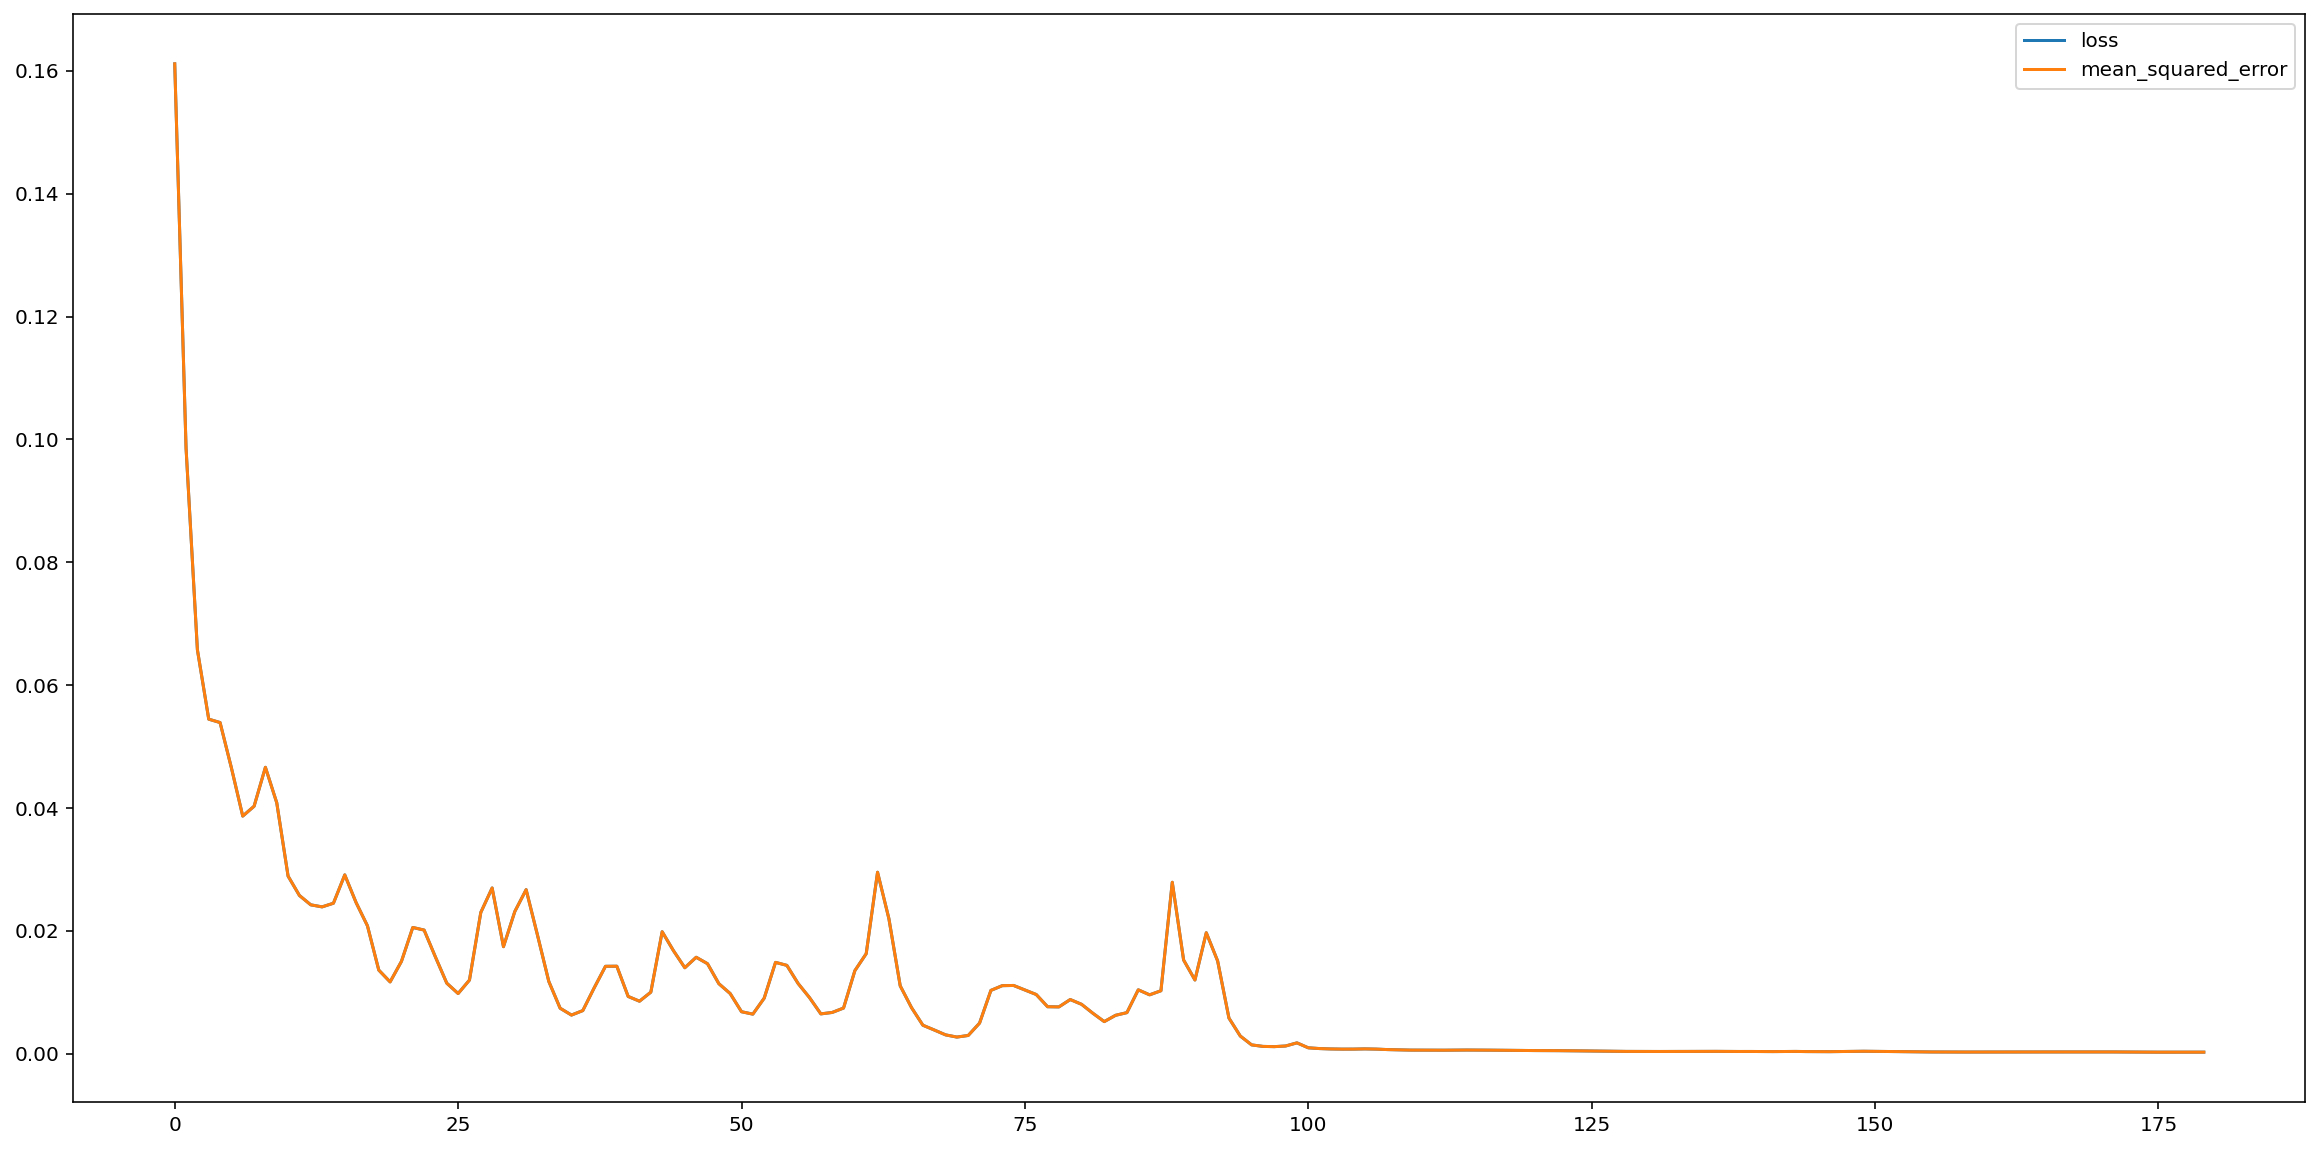

In [ ]:
df_100.plot(figsize=(20,10))

## Predict next offset

In [47]:
def create_ground_truth_and_preprocess_sequence(sequence, min_offset, max_offset):
    print(sequence)
    #prendo tutti gli elementi del batch tranne l'ultimo
    input = sequence[:-1]
    #prendo l'ultimo elemento e lo utilizzo come groudn truth
    grt = sequence[-1]
 
    label = min_max_denormalization_2(grt[2], min_offset, max_offset)

    return input, label

dataset_of_training_sequences = training_sequences.map(lambda s: create_ground_truth_and_preprocess_sequence(s, min_offset, max_offset),  num_parallel_calls=tf.data.experimental.AUTOTUNE)

Tensor("args_0:0", shape=(501, 3), dtype=float64)


In [48]:
for seq, target in dataset_of_training_sequences.take(3):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 3):', seq[0: 3])
  print()
  print('target:', target)

sequence shape: (500, 3)
sequence elements (first 3): tf.Tensor(
[[0.11438356 0.09302326 0.0420105 ]
 [0.43287671 0.01744186 0.12753188]
 [0.50136986 0.26162791 0.01650413]], shape=(3, 3), dtype=float64)

target: tf.Tensor(0.03, shape=(), dtype=float64)
sequence shape: (500, 3)
sequence elements (first 3): tf.Tensor(
[[0.43287671 0.01744186 0.12753188]
 [0.50136986 0.26162791 0.01650413]
 [0.11438356 0.03488372 0.01275319]], shape=(3, 3), dtype=float64)

target: tf.Tensor(0.06, shape=(), dtype=float64)
sequence shape: (500, 3)
sequence elements (first 3): tf.Tensor(
[[0.50136986 0.26162791 0.01650413]
 [0.11438356 0.03488372 0.01275319]
 [0.98630137 0.02325581 0.04726182]], shape=(3, 3), dtype=float64)

target: tf.Tensor(0.08, shape=(), dtype=float64)


In [49]:
batch_size = 128
training_buffer_size = len(notes)- seq_length  # the number of items in the training dataset

training_dataset = (dataset_of_training_sequences
                        .batch(batch_size, drop_remainder=True)
                        .cache()
                        .prefetch(tf.data.experimental.AUTOTUNE))

In [50]:
#using functional API...
input_shape = (seq_length, 3)

#core of the model
inputs = Input(input_shape)
lstm_last_state = LSTM(int(n_vocabs*0.16), return_sequences=True)(inputs)
lstm_last_state = LSTM(int(n_vocabs*0.2), return_sequences=True)(lstm_last_state)
lstm_last_state = LSTM(int(n_vocabs*0.25))(lstm_last_state)

dense = Dense(int(n_vocabs*0.3))(lstm_last_state)

offset_output = Dense(1,activation="relu")(dense)

offset_predictor = Model(inputs, outputs=offset_output)

In [51]:

optimizer = Adam(learning_rate=0.0001)

#carico precedenti pesi
offset_predictor.load_weights("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/models/nocturnes_offset_predictor_500_2.hdf5")

offset_predictor.compile(loss="mean_squared_error",  optimizer=optimizer, metrics=['mean_squared_error'])

offset_predictor.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500, 3)]          0         
                                                                 
 lstm_9 (LSTM)               (None, 500, 233)          220884    
                                                                 
 lstm_10 (LSTM)              (None, 500, 292)          614368    
                                                                 
 lstm_11 (LSTM)              (None, 365)               960680    
                                                                 
 dense_6 (Dense)             (None, 438)               160308    
                                                                 
 dense_7 (Dense)             (None, 1)                 439       
                                                                 
Total params: 1,956,679
Trainable params: 1,956,679
Non-tra

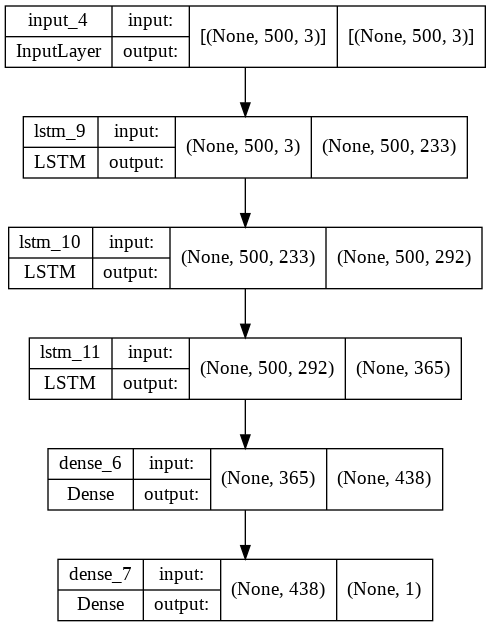

In [52]:
plot_model(offset_predictor, show_shapes=True, show_layer_names=True)

In [ ]:
filepath = "/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/models/nocturnes_offset_predictor_500_2.hdf5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='mean_squared_error',
    verbose=0,
    save_best_only=True,
    mode='min'
)

callbacks = [checkpoint]

epochs = 120

history = offset_predictor.fit(training_dataset,epochs=epochs,callbacks=callbacks, verbose=1, shuffle=True)

In [ ]:
df = pd.DataFrame(history.history)

In [ ]:
df.to_pickle("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/training_results/training_offset_2.pkl")

Loading (for documentation) the training results when using sequences of 100

In [ ]:
#load training info for sequences of 100 elements 
df_100 = pd.read_pickle("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/training_results/training_offset_1.pkl")

In [ ]:

#min loss achived
min_loss_with_100 = df_100['loss'].min()

print("min loss achived", min_loss_with_100)

min loss achived 0.0025564455427229404


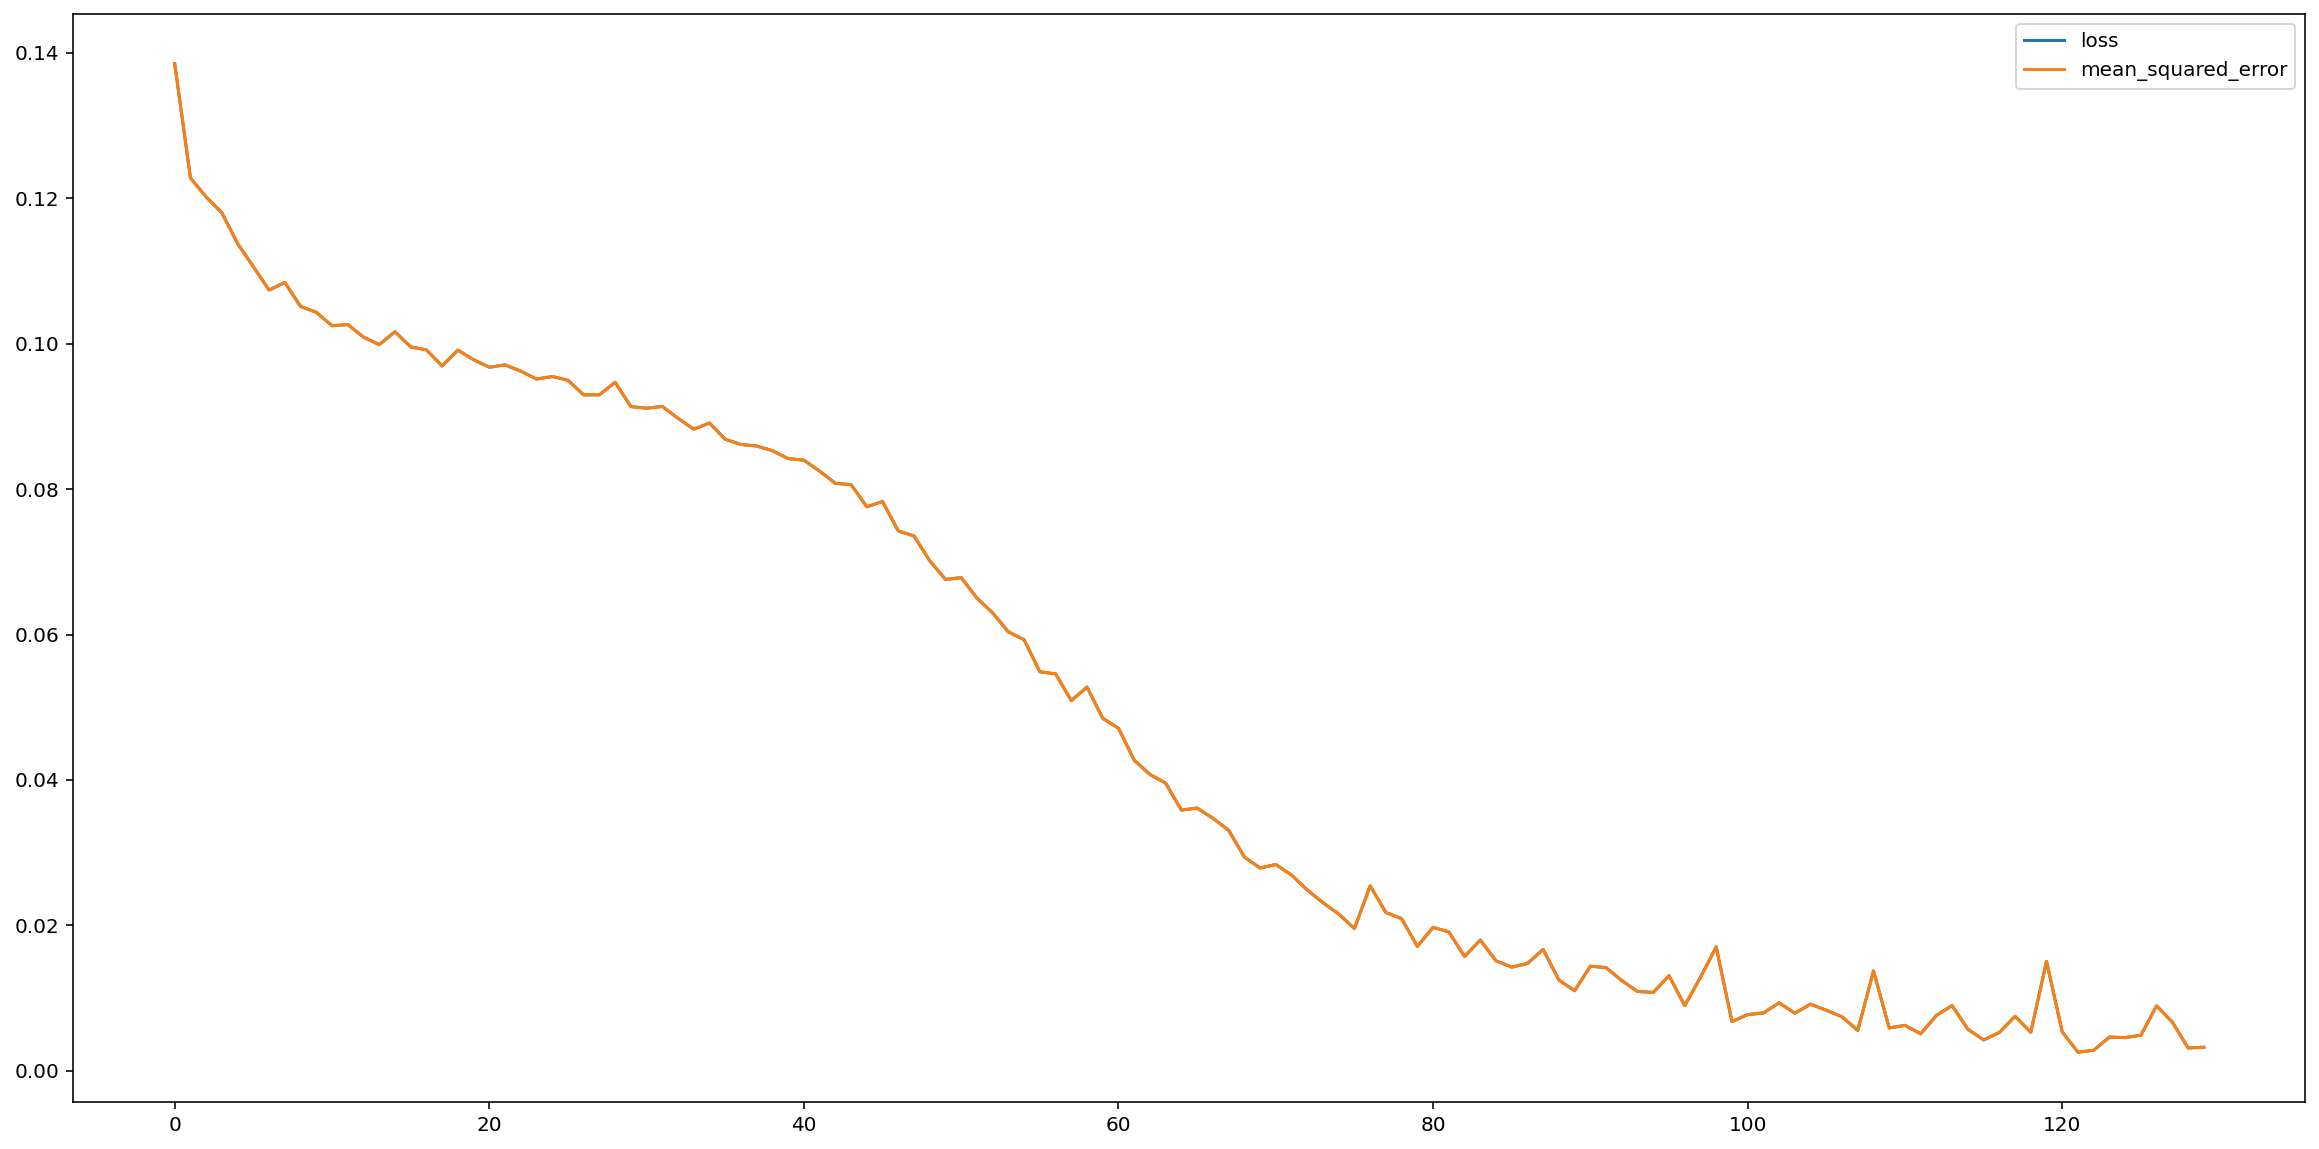

In [ ]:
df_100.plot(figsize=(20,10))

Loading (for documentation) the training results when using sequences of 500

In [ ]:
#load training info for sequences of 100 elements 
df_100 = pd.read_pickle("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/training_results/training_offset_2.pkl")

In [ ]:

#min loss achived
min_loss_with_100 = df_100['loss'].min()

print("min loss achived", min_loss_with_100)

min loss achived 0.0001600655377842486


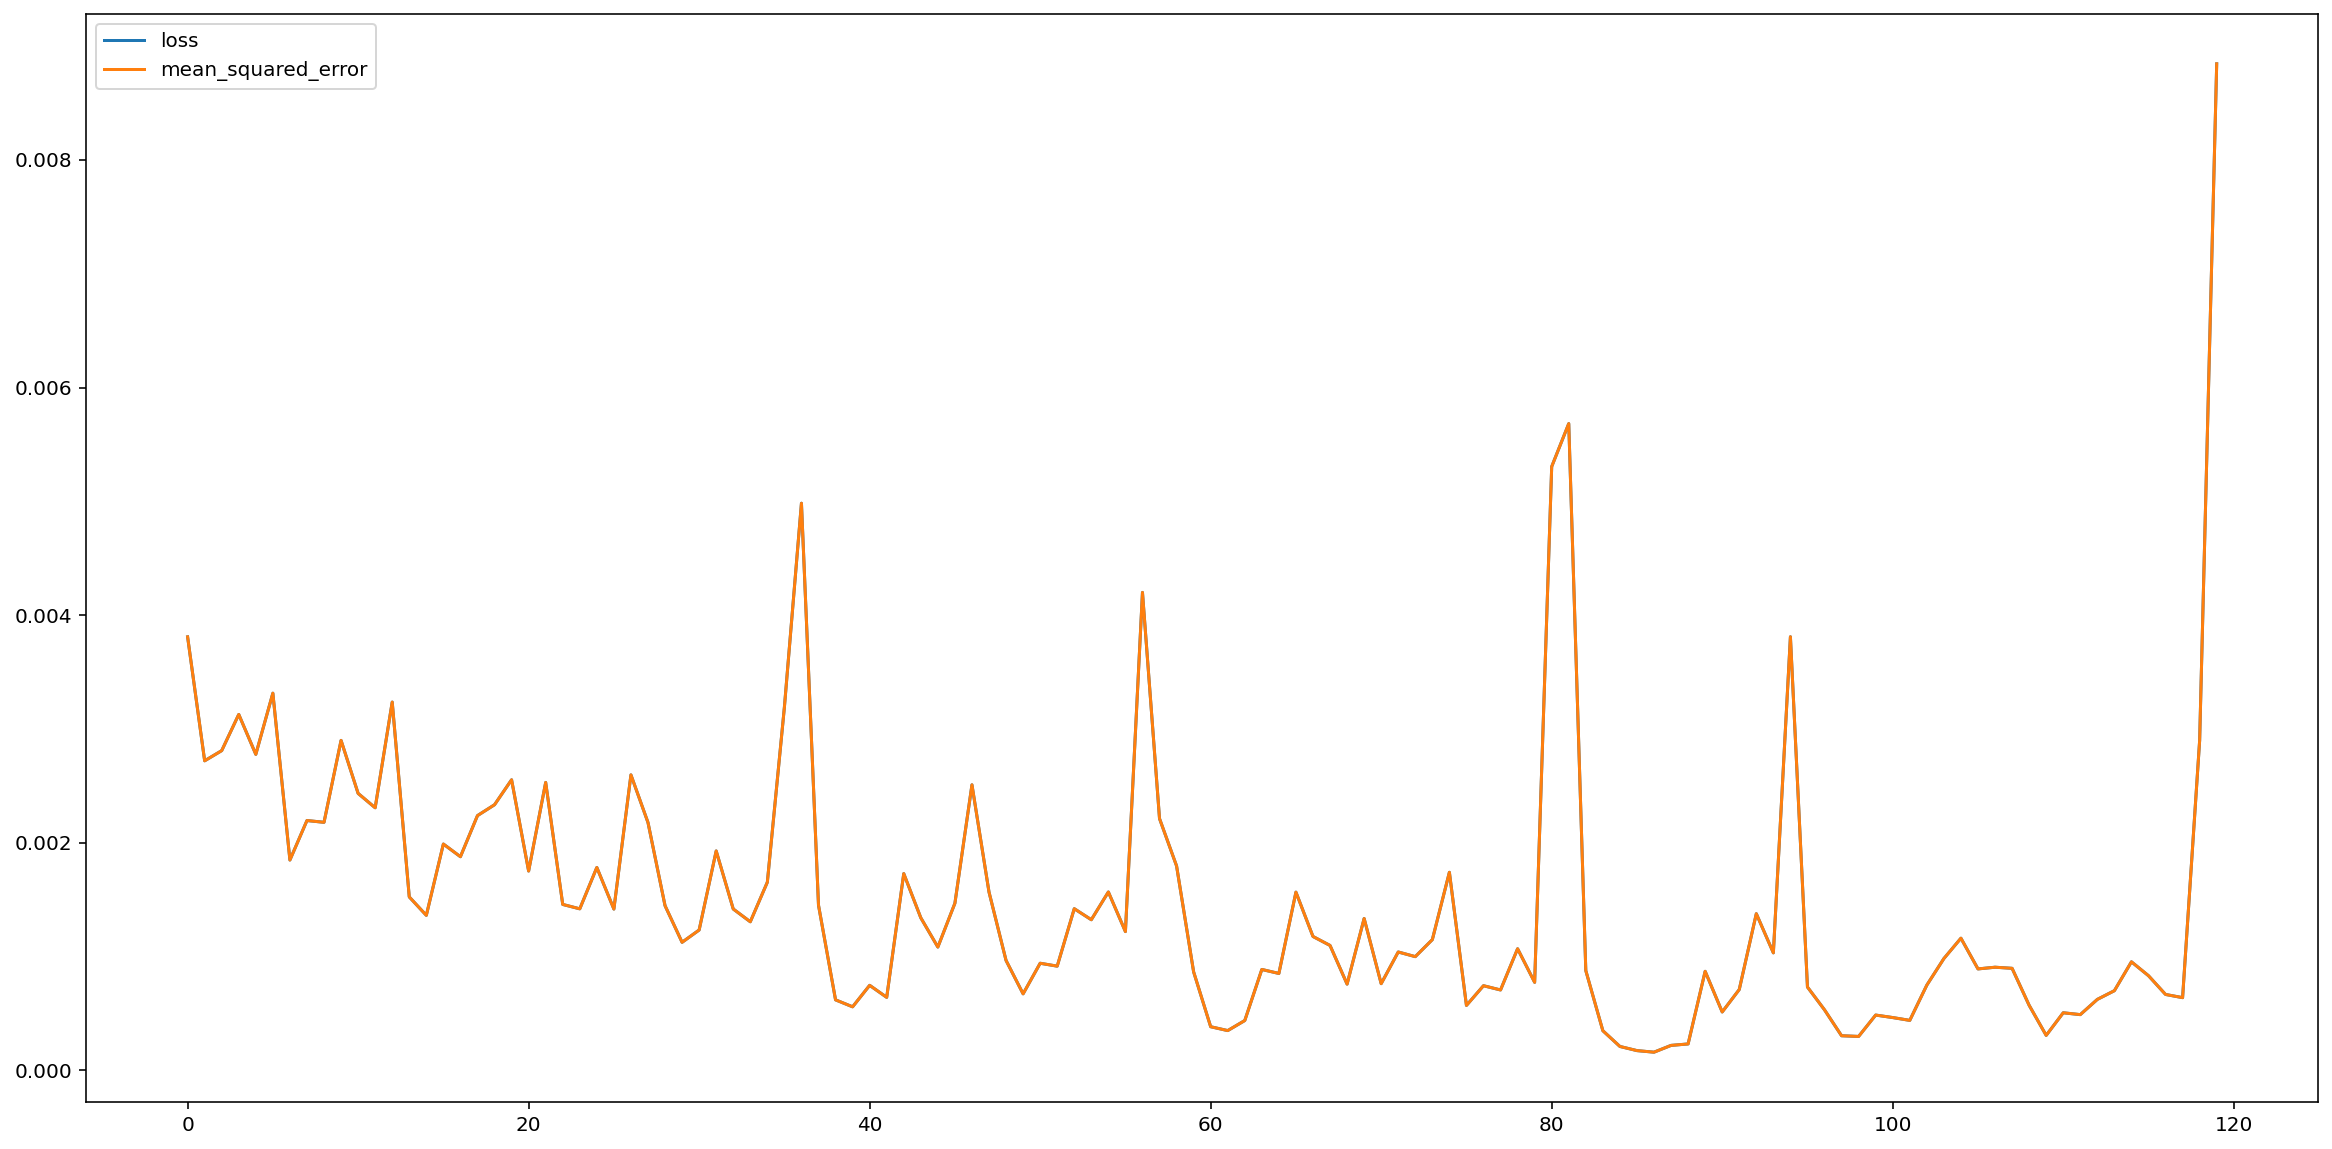

In [ ]:
df_100.plot(figsize=(20,10))

## Trident model: combine models into one

Now let's assemble the three models trained above to form a single model that predicts next note, duration and offset.

In [ ]:
from tensorflow.keras.layers import Concatenate

seq_length = 500

#Input::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
input_shape = (seq_length, 3)
inputs = Input(input_shape)

#pitch predictor::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
lstm_last_state_1 = LSTM(int(n_vocabs*0.3), return_sequences=True)(inputs)
lstm_last_state_1 = LSTM(int(n_vocabs*0.4), return_sequences=True)(lstm_last_state_1)
lstm_last_state_1 = LSTM(int(n_vocabs*0.5))(lstm_last_state_1)
dense_1 = Dense(int(n_vocabs*0.6))(lstm_last_state_1)
pitch_output = Dense(n_vocabs,activation='softmax')(dense_1)

pitch_predictor = Model(inputs, outputs=pitch_output)
pitch_predictor.load_weights("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/models/nocturnes_pitch_predictor_500.hdf5")

#duration predictor:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
lstm_last_state_2 = LSTM(int(n_vocabs*0.15), return_sequences=True)(inputs)
lstm_last_state_2 = LSTM(int(n_vocabs*0.18), return_sequences=True)(lstm_last_state_2)
lstm_last_state_2 = LSTM(int(n_vocabs*0.2))(lstm_last_state_2)
dense_2 = Dense(int(n_vocabs*0.25))(lstm_last_state_2)
duration_output = Dense(1, activation="relu")(dense_2)

duration_predictor = Model(inputs, outputs=duration_output)
duration_predictor.load_weights("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/models/nocturnes_duration_predictor_500_3.hdf5")

#offset predictor:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
lstm_last_state_3 = LSTM(int(n_vocabs*0.16), return_sequences=True)(inputs)
lstm_last_state_3 = LSTM(int(n_vocabs*0.2), return_sequences=True)(lstm_last_state_3)
lstm_last_state_3 = LSTM(int(n_vocabs*0.25))(lstm_last_state_3)
dense_3 = Dense(int(n_vocabs*0.3))(lstm_last_state_3)
offset_output = Dense(1, activation="relu")(dense_3)

offset_predictor = Model(inputs, outputs=offset_output)
offset_predictor.load_weights("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/models/nocturnes_offset_predictor_500_2.hdf5")

#Trident model
concatenation_output_layer = Concatenate()([pitch_output, duration_output, offset_output])
trident_model = Model(inputs=inputs, outputs=concatenation_output_layer)

trident_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 3)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 500, 438)     774384      ['input_1[0][0]']                
                                                                                                  
 lstm_3 (LSTM)                  (None, 500, 219)     195348      ['input_1[0][0]']                
                                                                                                  
 lstm_6 (LSTM)                  (None, 500, 233)     220884      ['input_1[0][0]']                
                                                                                            

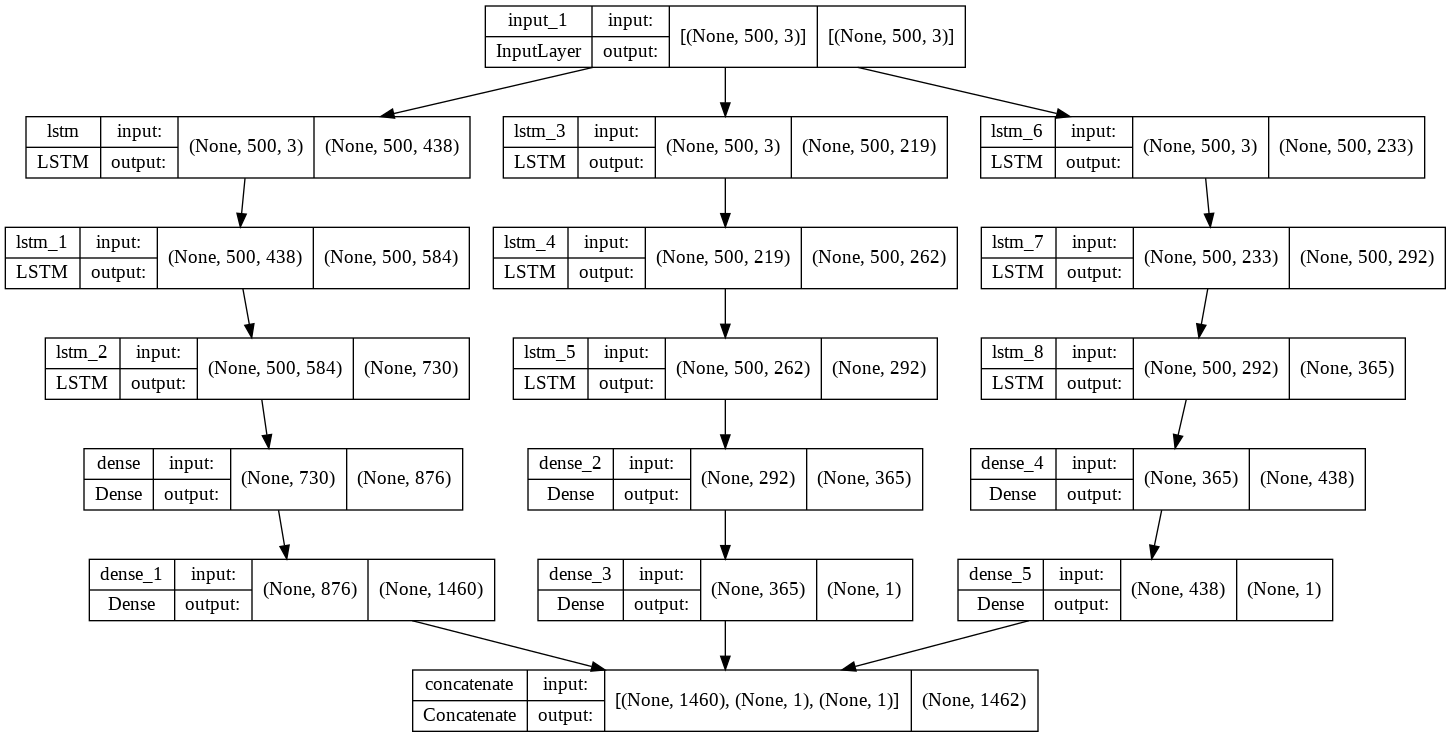

In [ ]:
plot_model(trident_model, show_shapes=True, show_layer_names=True)

# Generate music

In [ ]:
#load dataframe
notes = pd.read_pickle("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/nocturnes - aggregation/notes_nocturnes.pkl")
indexes_new_composition = numpy.load("/content/drive/MyDrive/Giulio Federico 548403 (Progetto CIDL)/RNN music generator/2. Trident architecture (for Nocturnes)/nocturnes - aggregation/indexes_new_composition_nocturnes.npy")

In [ ]:
notes

,pitch,duration,offset
0,A#4,1.7,0.56
1,B4,0.4,1.70
2,C#2,4.6,0.22
3,A#4,0.7,0.17
4,G#4,0.5,0.63
...,...,...,...
22595,F2,4.3,0.17
22596,A#2,4.1,0.17
22597,A#3.D4,1.8,0.10
22598,D3,1.8,0.01


From a primer (a sequence of 100 notes/chords starting from random), create the sequences note

In [ ]:
def normalize_pitch(pitch, n_vocabs):

  #convert pitch to its integer rapresentation
  pitch = note_to_int[pitch]
  #normalize input
  pitch = min_max_normalization(pitch, 0, n_vocabs)

  #return normalize data
  return pitch

number_of_predictions = 2500
predicted_notes = []
predicted_duration = []
predicted_offset = []
probabilities = []
#create primer

starting_point = 10900
sequence_length = 500

primer_notes = notes.iloc[starting_point:(starting_point + sequence_length)].copy()
primer_notes['pitch'] = primer_notes['pitch'].map(lambda pitch: normalize_pitch(pitch, n_vocabs))
primer_notes['duration'] = primer_notes['duration'].map(lambda duration: min_max_normalization(duration, min_duration, max_duration))
primer_notes['offset'] = primer_notes['offset'].map(lambda offset: min_max_normalization(offset, min_offset, max_offset))

input = primer_notes.to_numpy()
input = numpy.expand_dims(input, axis=0)

for i in numpy.arange(0,number_of_predictions):
  print(i)
  #print("\n ---------------------------------------------------------------------------------")
  #print("  La sequenza di input è:", input)

  prediction = trident_model.predict(input)[0]

  pitch_probabilities = prediction[0:n_vocabs]
  probabilities.append(pitch_probabilities)
  
  next_note = numpy.random.choice(pitchnames, p=pitch_probabilities)
  next_pitch_integer_rapresentation = note_to_int[next_note]

  next_duration = prediction[n_vocabs]
  next_offset = prediction[n_vocabs+1]
  #print("  PREDIZIONE ",i," --> ", next_pitch_integer_rapresentation, ",", next_duration,",", next_offset ) 

  #save predicted note/chord with its duration and offset
  predicted_notes.append(next_note)
  predicted_duration.append(next_duration)
  predicted_offset.append(next_offset)

  #create new tern
  p = min_max_normalization(next_pitch_integer_rapresentation, 0, n_vocabs)
  d = min_max_normalization(next_duration, min_duration, max_duration)
  o = min_max_normalization(next_offset, min_offset, max_offset)

  #next tern
  next_tern = [[p,d,o]]
  new_input = input[0][1:] #remove first tern
  new_input = numpy.insert(new_input,sequence_length-1,next_tern,0) #add new tern

  input = new_input
  input = numpy.expand_dims(input, axis=0)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Plot some distributions for the documentation

Text(0.5, 1.0, '1st note prediction')

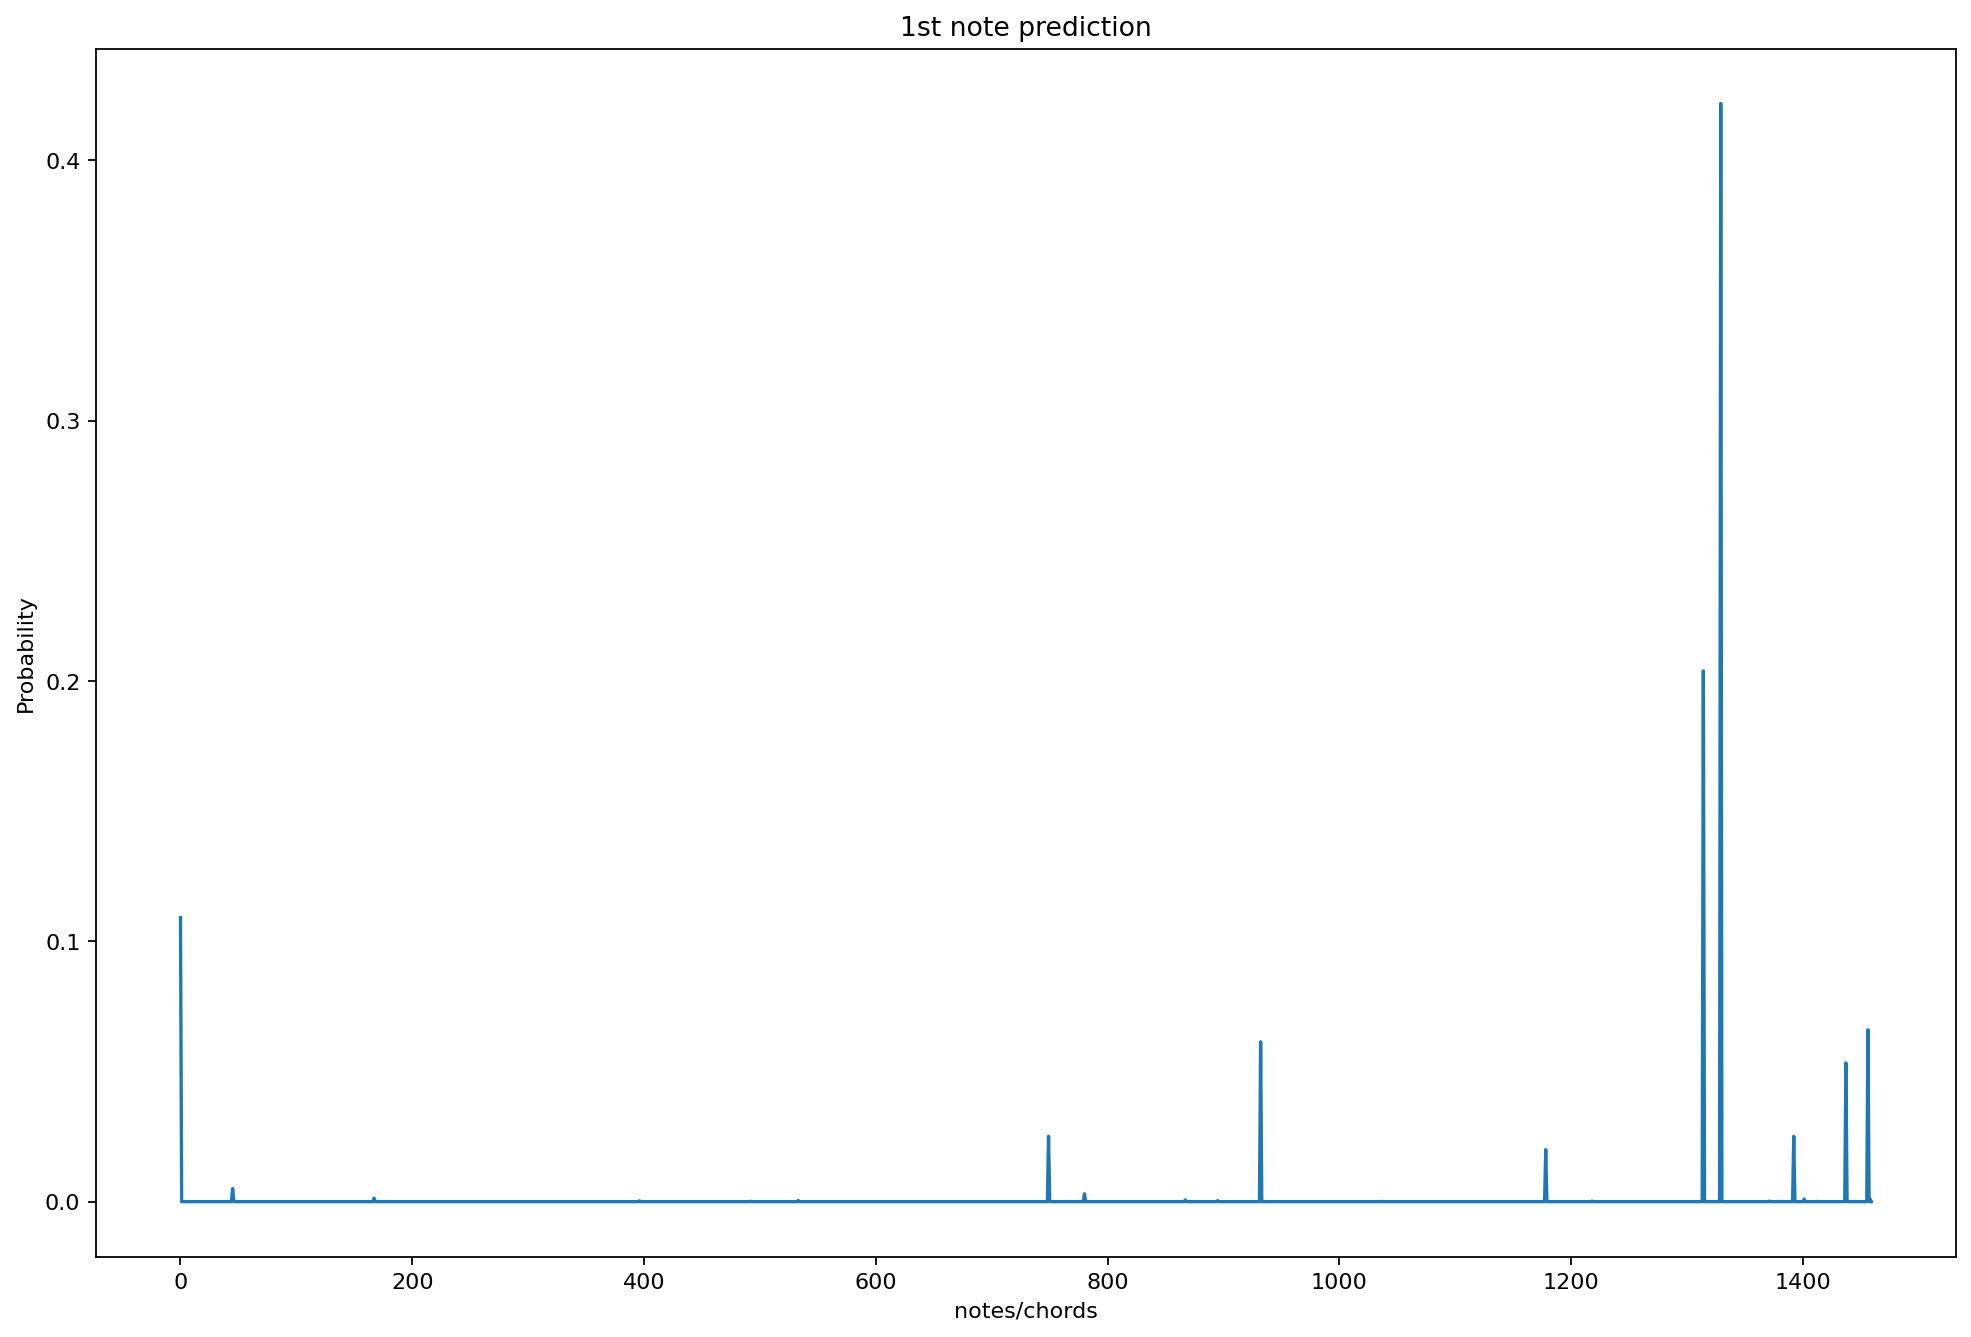

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(15, 10), dpi=80)

plt.plot(probabilities[0]) 
plt.ylabel('Probability')
plt.xlabel('notes/chords')
plt.title("1st note prediction")

Text(0.5, 1.0, '40th note prediction')

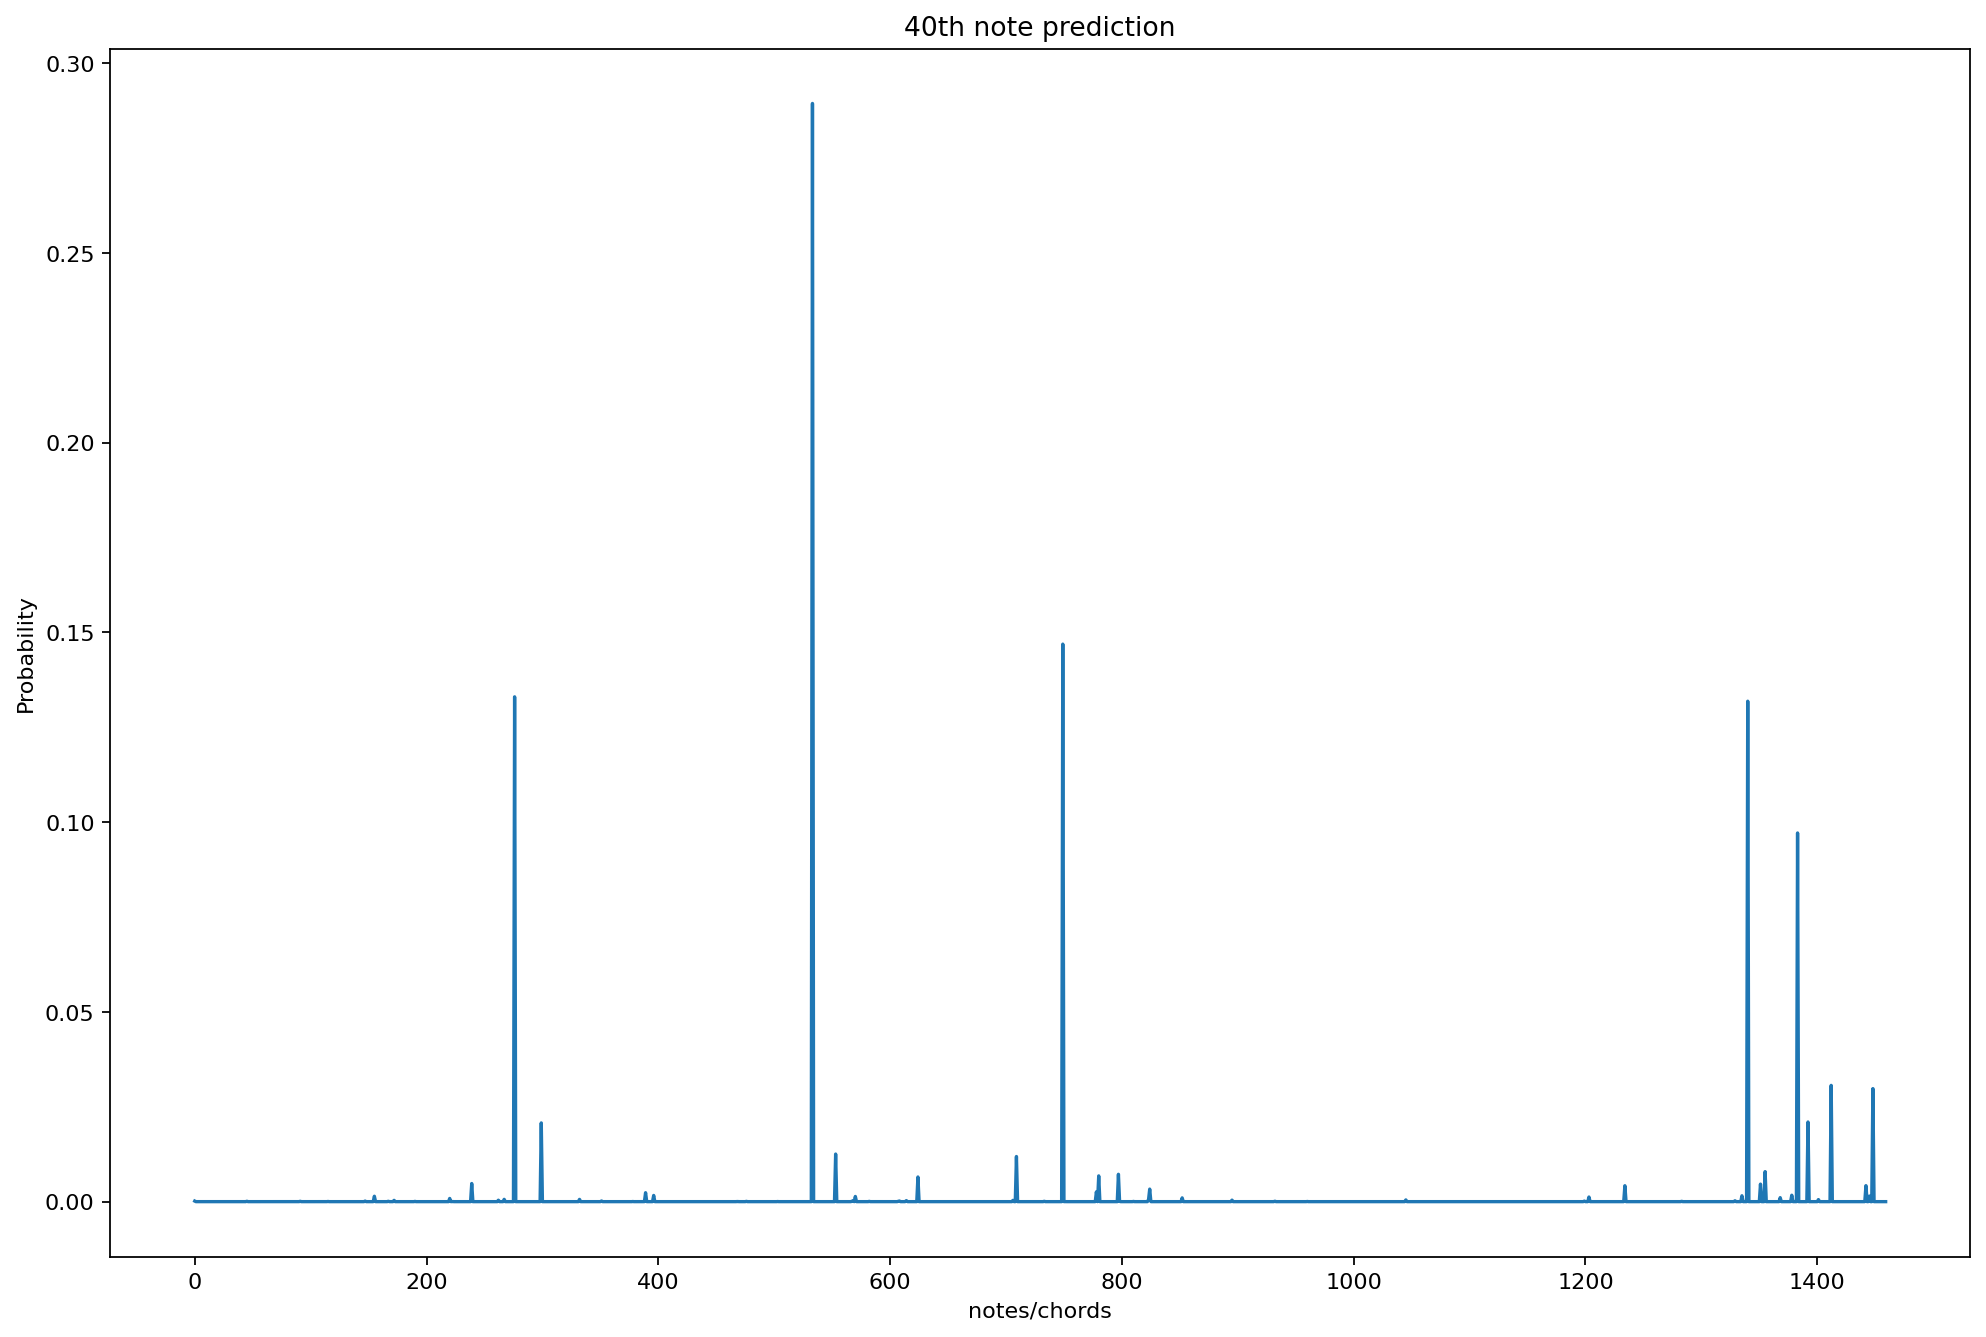

In [ ]:
figure(figsize=(15, 10), dpi=80)

plt.plot(probabilities[40]) 
plt.ylabel('Probability')
plt.xlabel('notes/chords')
plt.title("40th note prediction")

Text(0.5, 1.0, '270th note prediction')

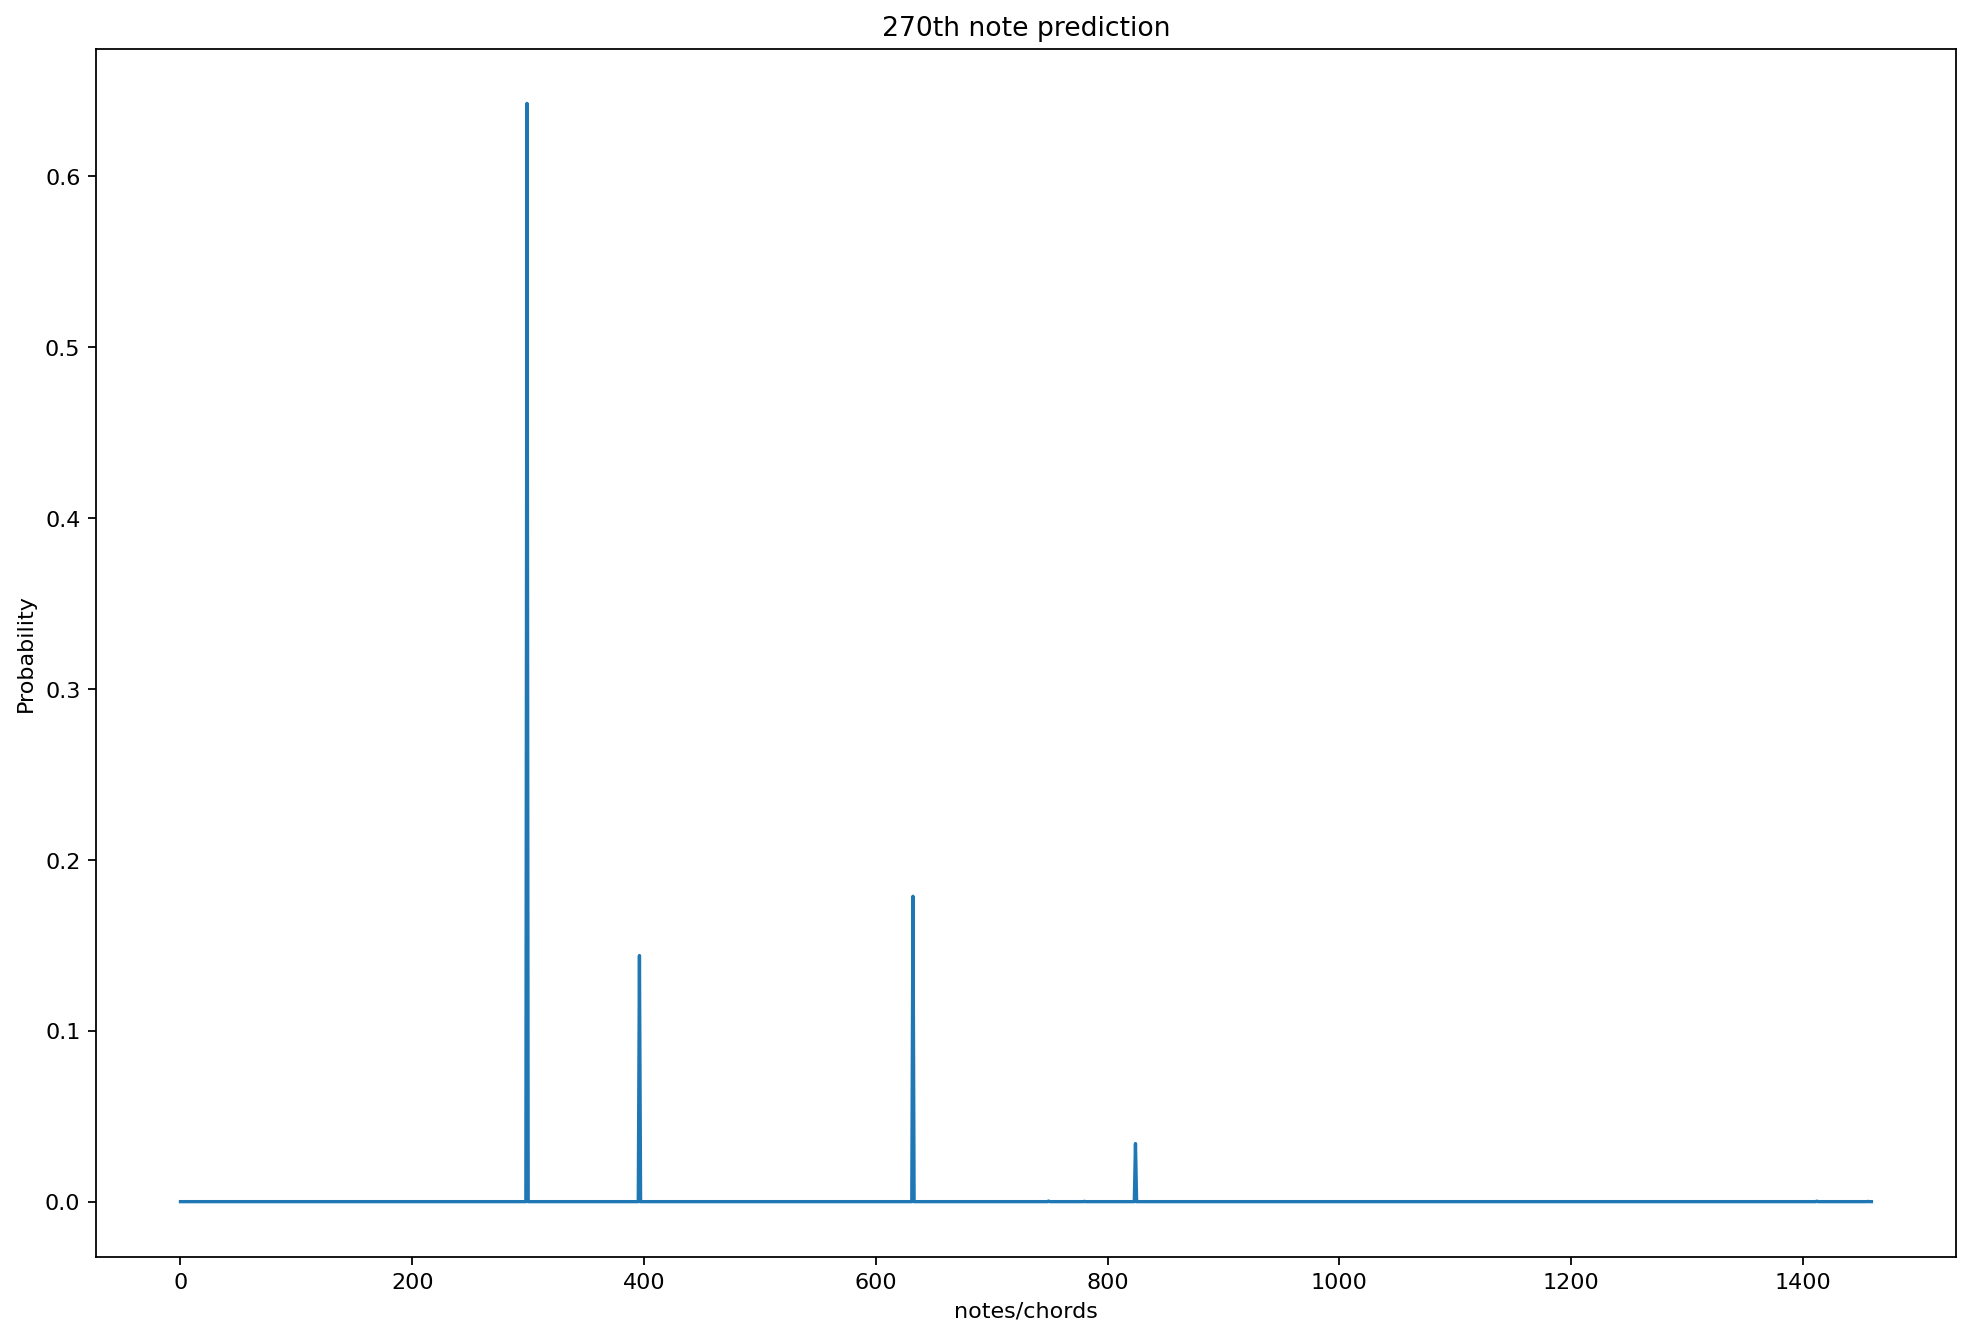

In [ ]:
figure(figsize=(15, 10), dpi=80)

plt.plot(probabilities[270]) 
plt.ylabel('Probability')
plt.xlabel('notes/chords')
plt.title("270th note prediction")

Text(0.5, 1.0, '420th note prediction')

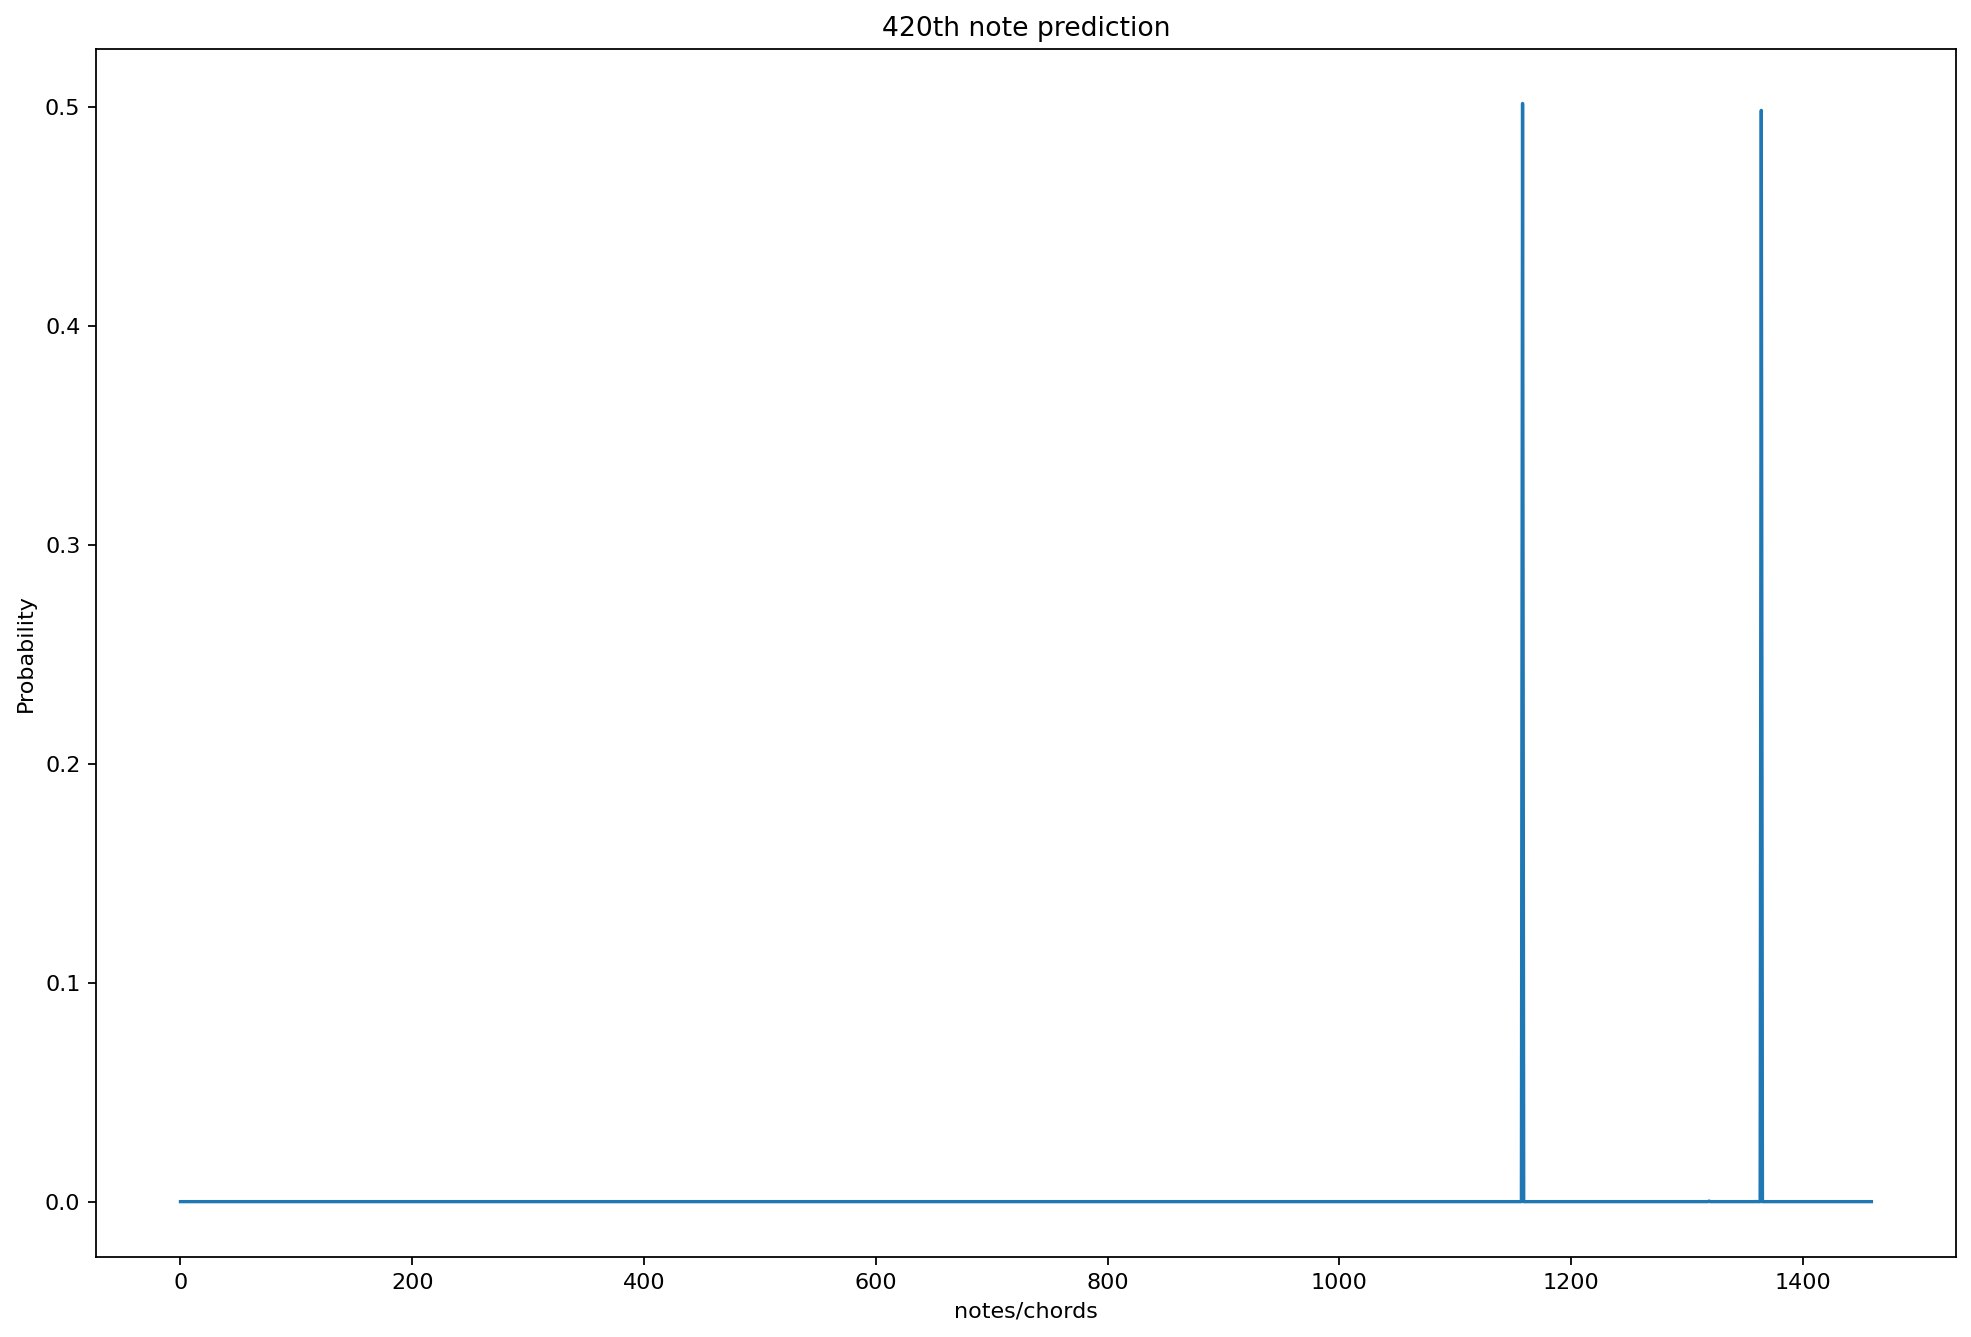

In [ ]:
figure(figsize=(15, 10), dpi=80)

plt.plot(probabilities[420]) 
plt.ylabel('Probability')
plt.xlabel('notes/chords')
plt.title("420th note prediction")

Text(0.5, 1.0, '720th note prediction')

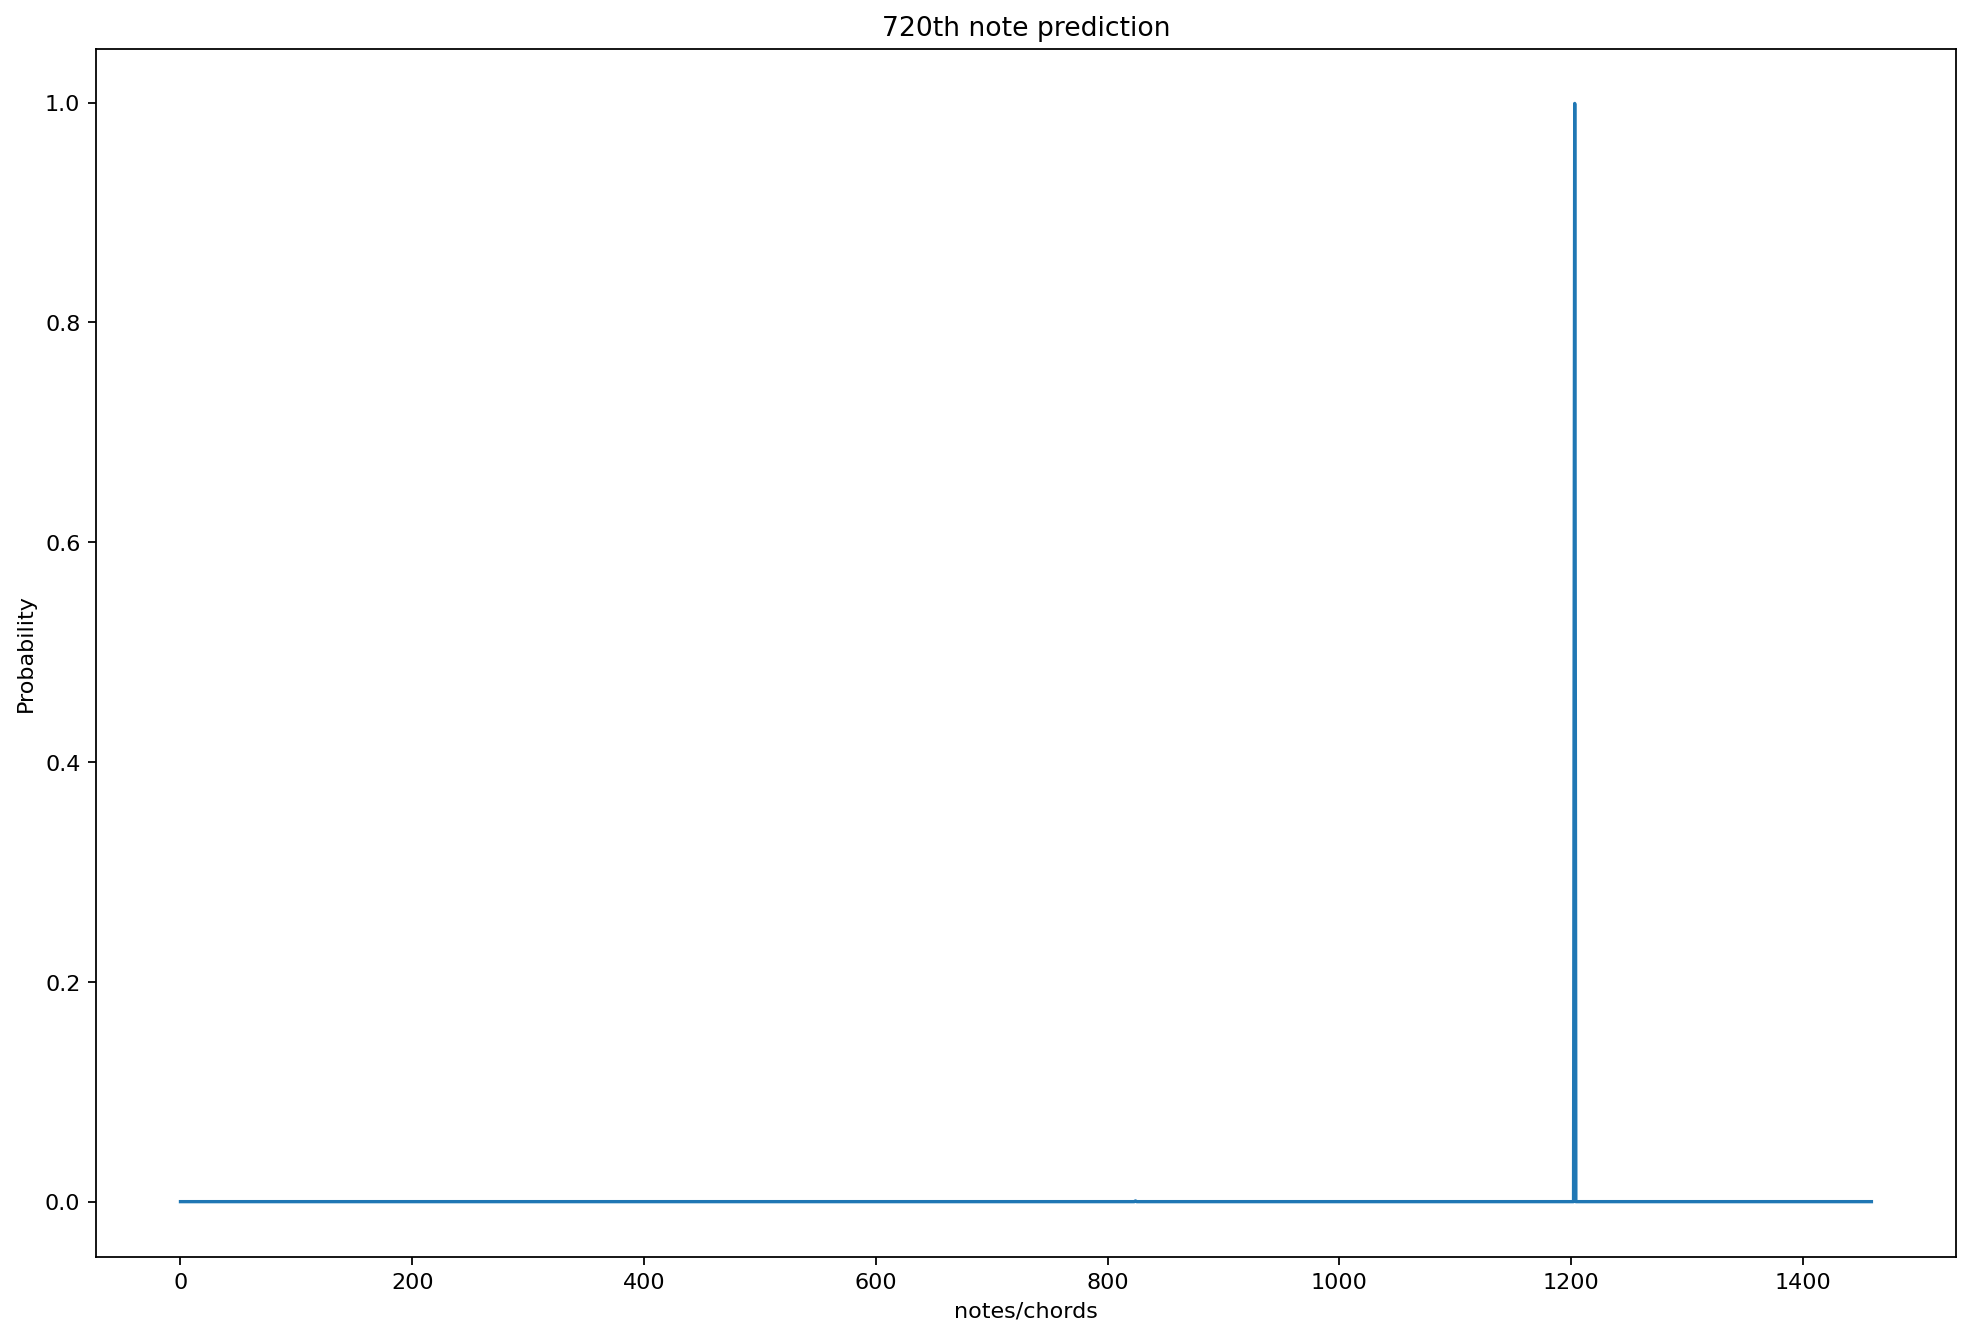

In [ ]:
figure(figsize=(15, 10), dpi=80)

plt.plot(probabilities[750]) 
plt.ylabel('Probability')
plt.xlabel('notes/chords')
plt.title("720th note prediction")

Text(0.5, 1.0, '1000th note prediction')

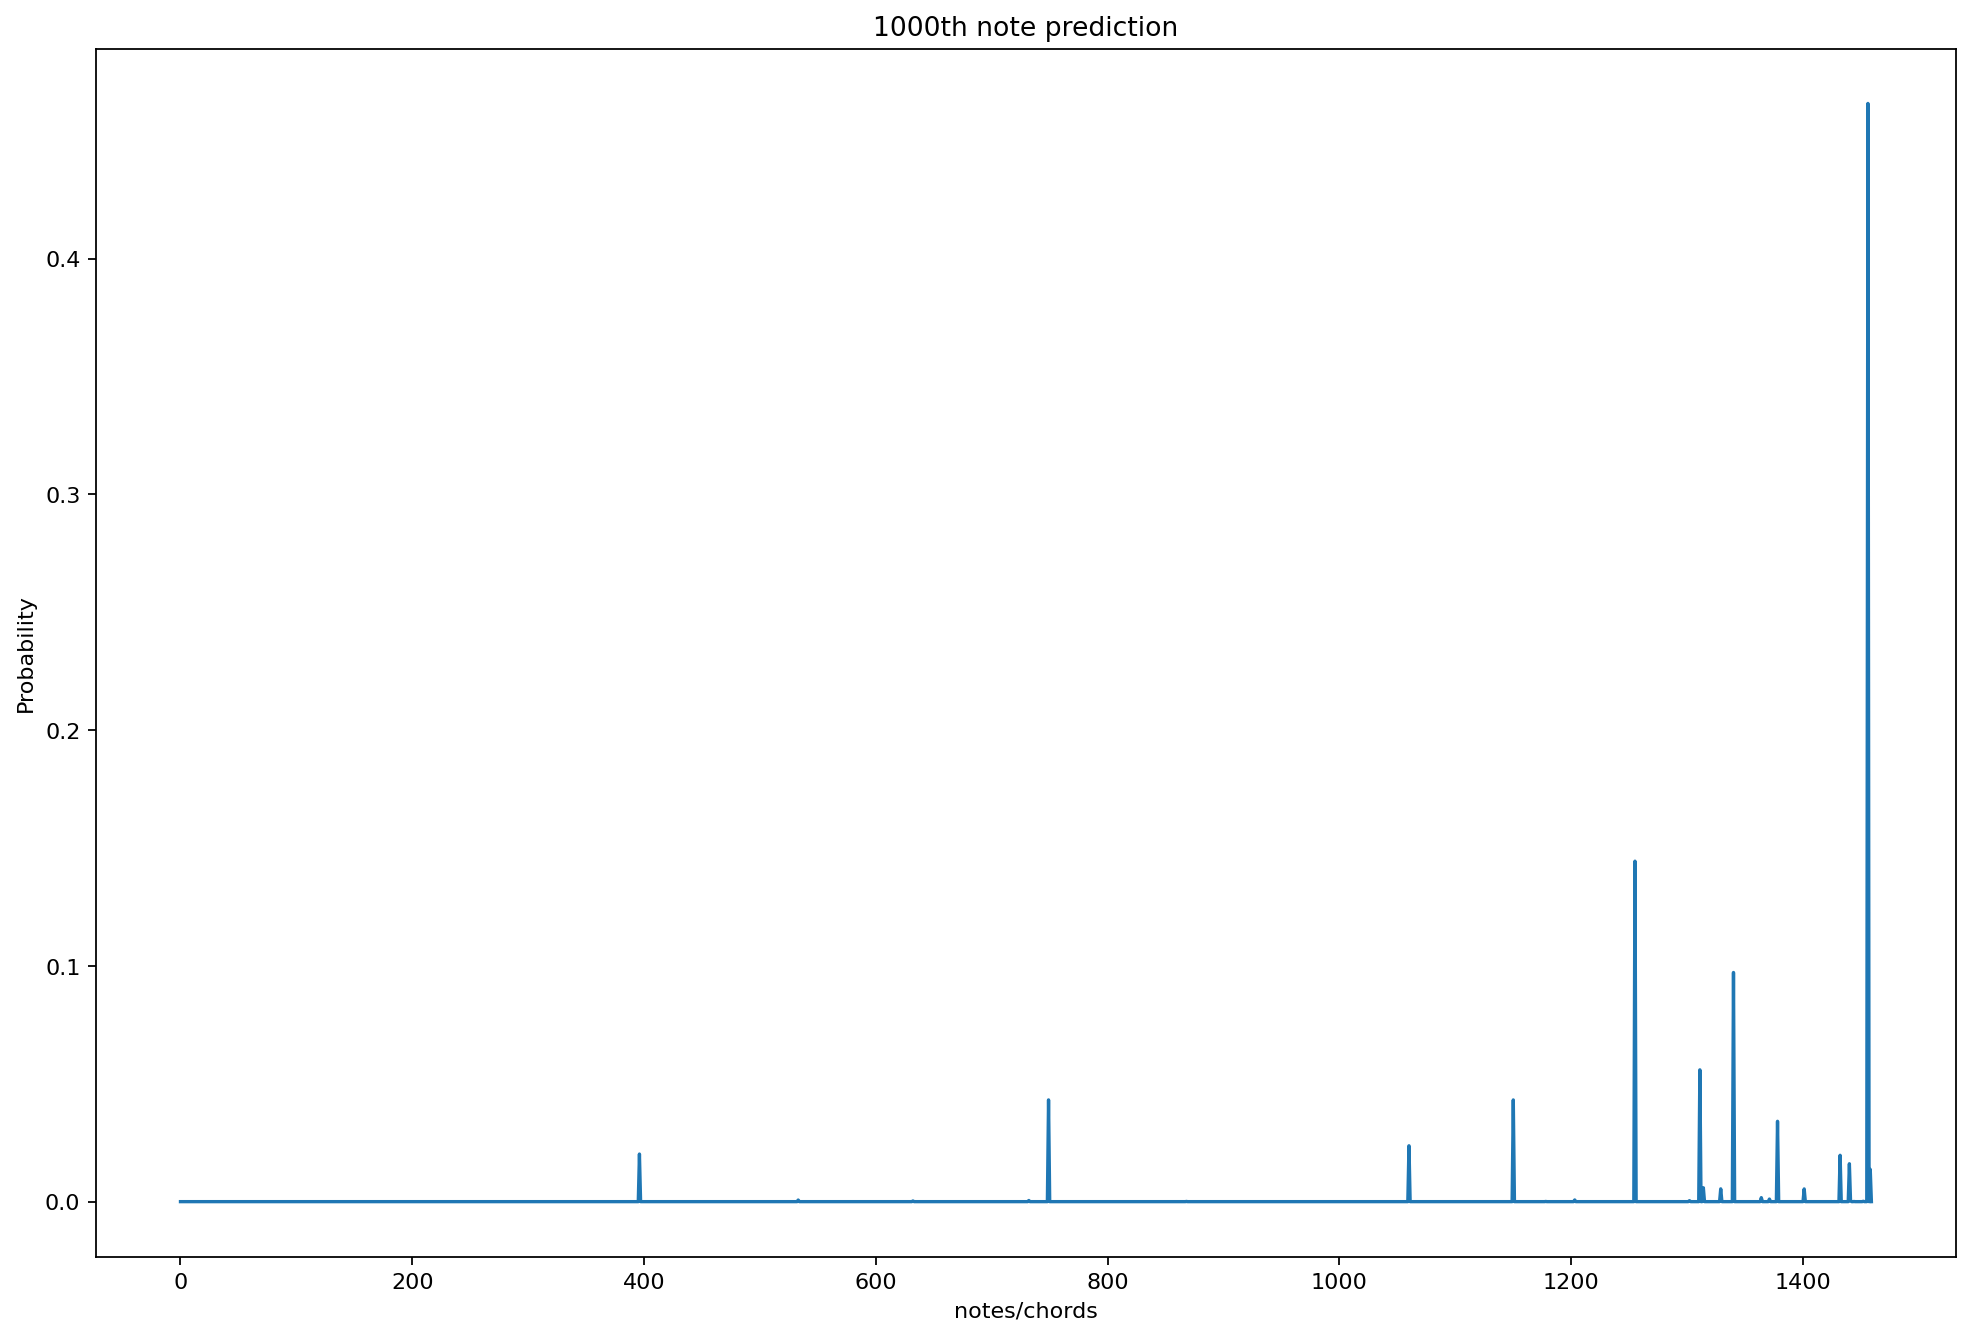

In [ ]:
figure(figsize=(15, 10), dpi=80)

plt.plot(probabilities[1000]) 
plt.ylabel('Probability')
plt.xlabel('notes/chords')
plt.title("1000th note prediction")

Text(0.5, 1.0, '1600th note prediction')

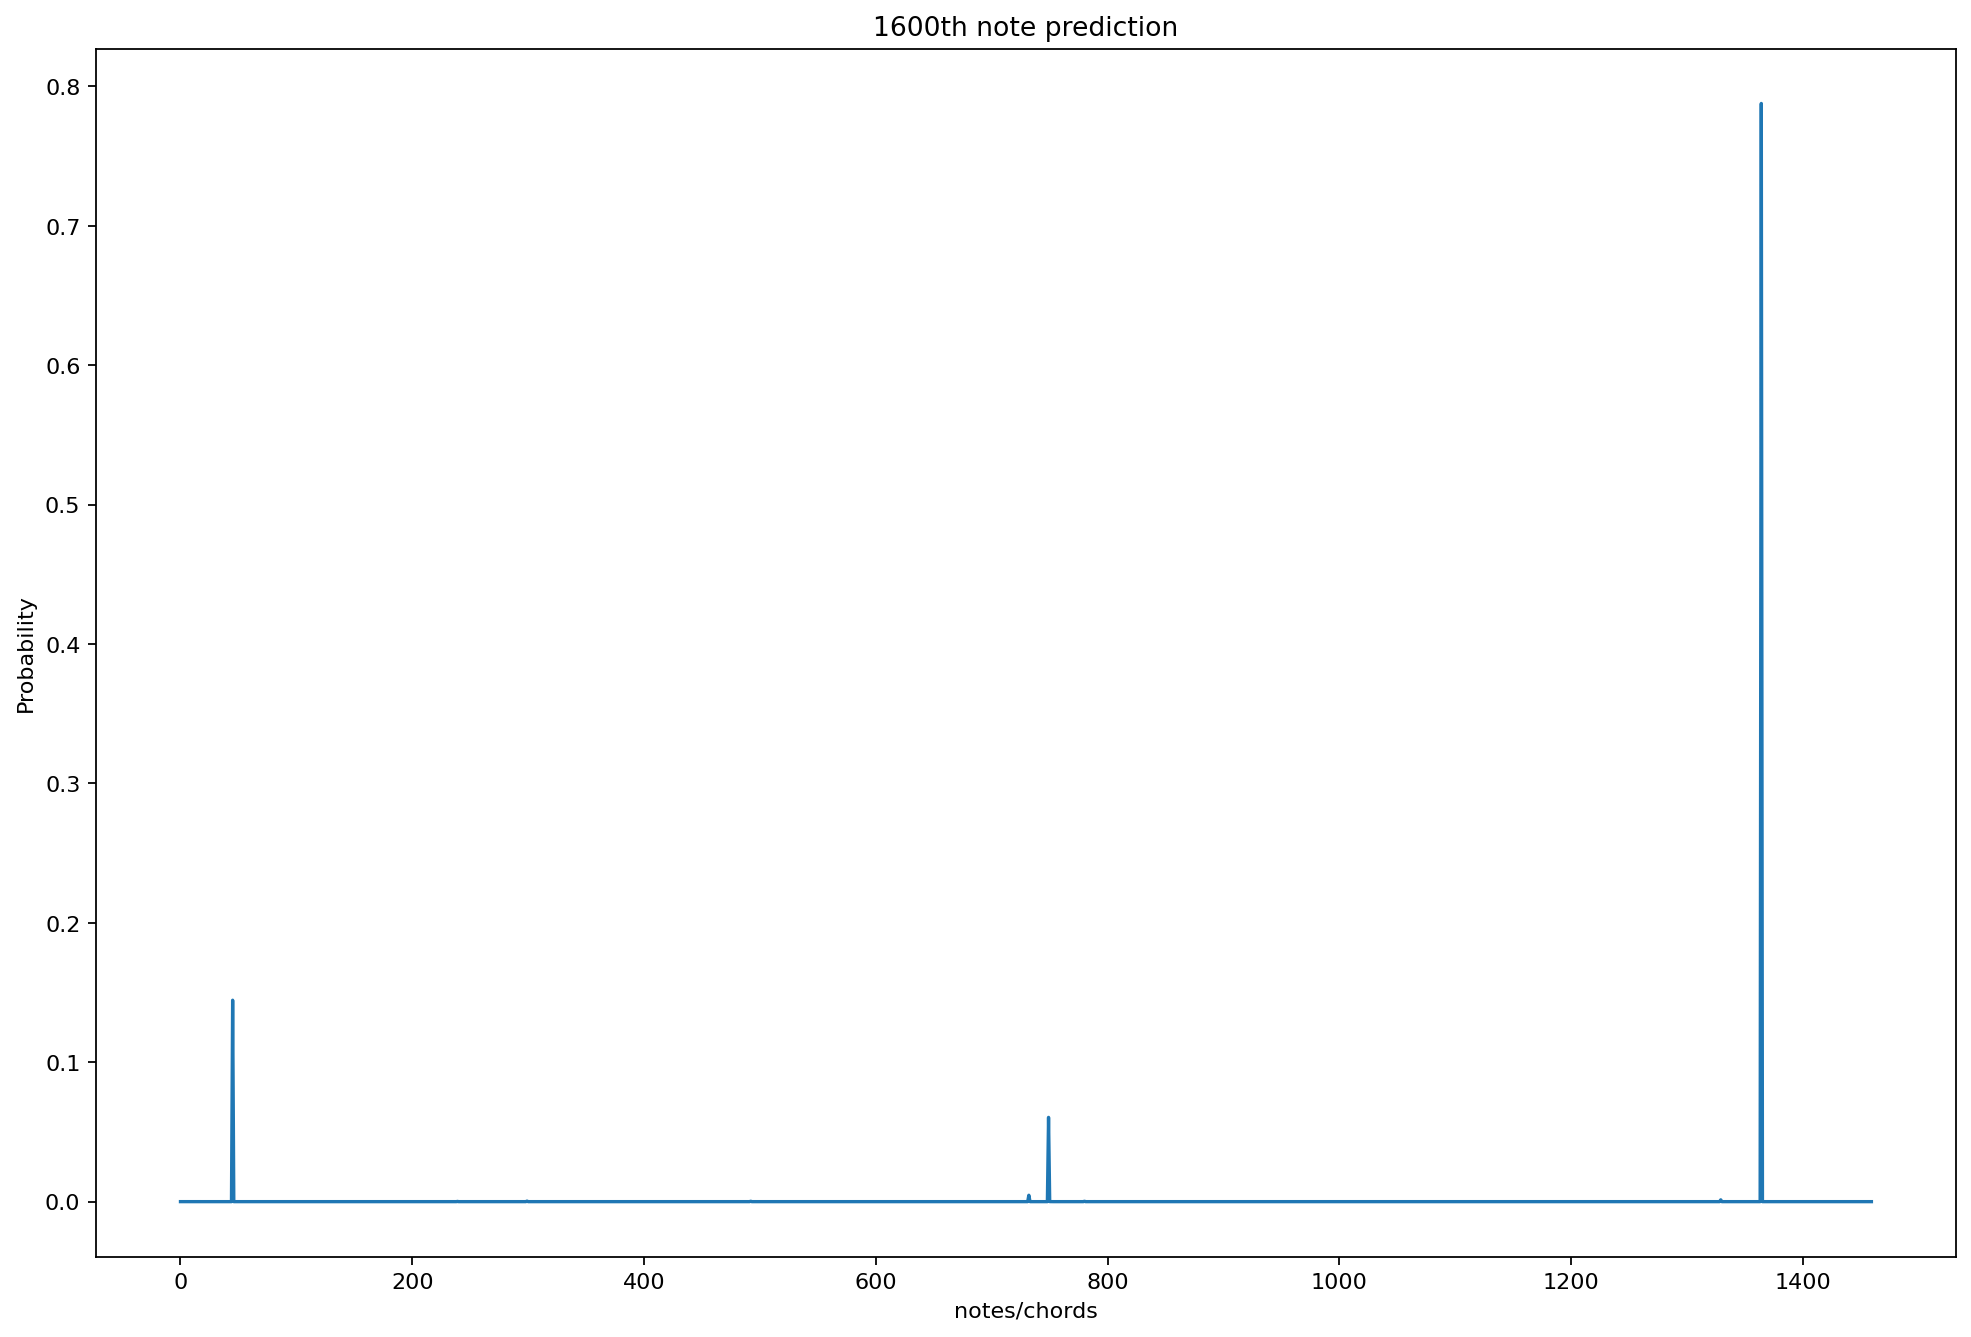

In [ ]:
figure(figsize=(15, 10), dpi=80)

plt.plot(probabilities[1600]) 
plt.ylabel('Probability')
plt.xlabel('notes/chords')
plt.title("1600th note prediction")

Text(0.5, 1.0, '2000th note prediction')

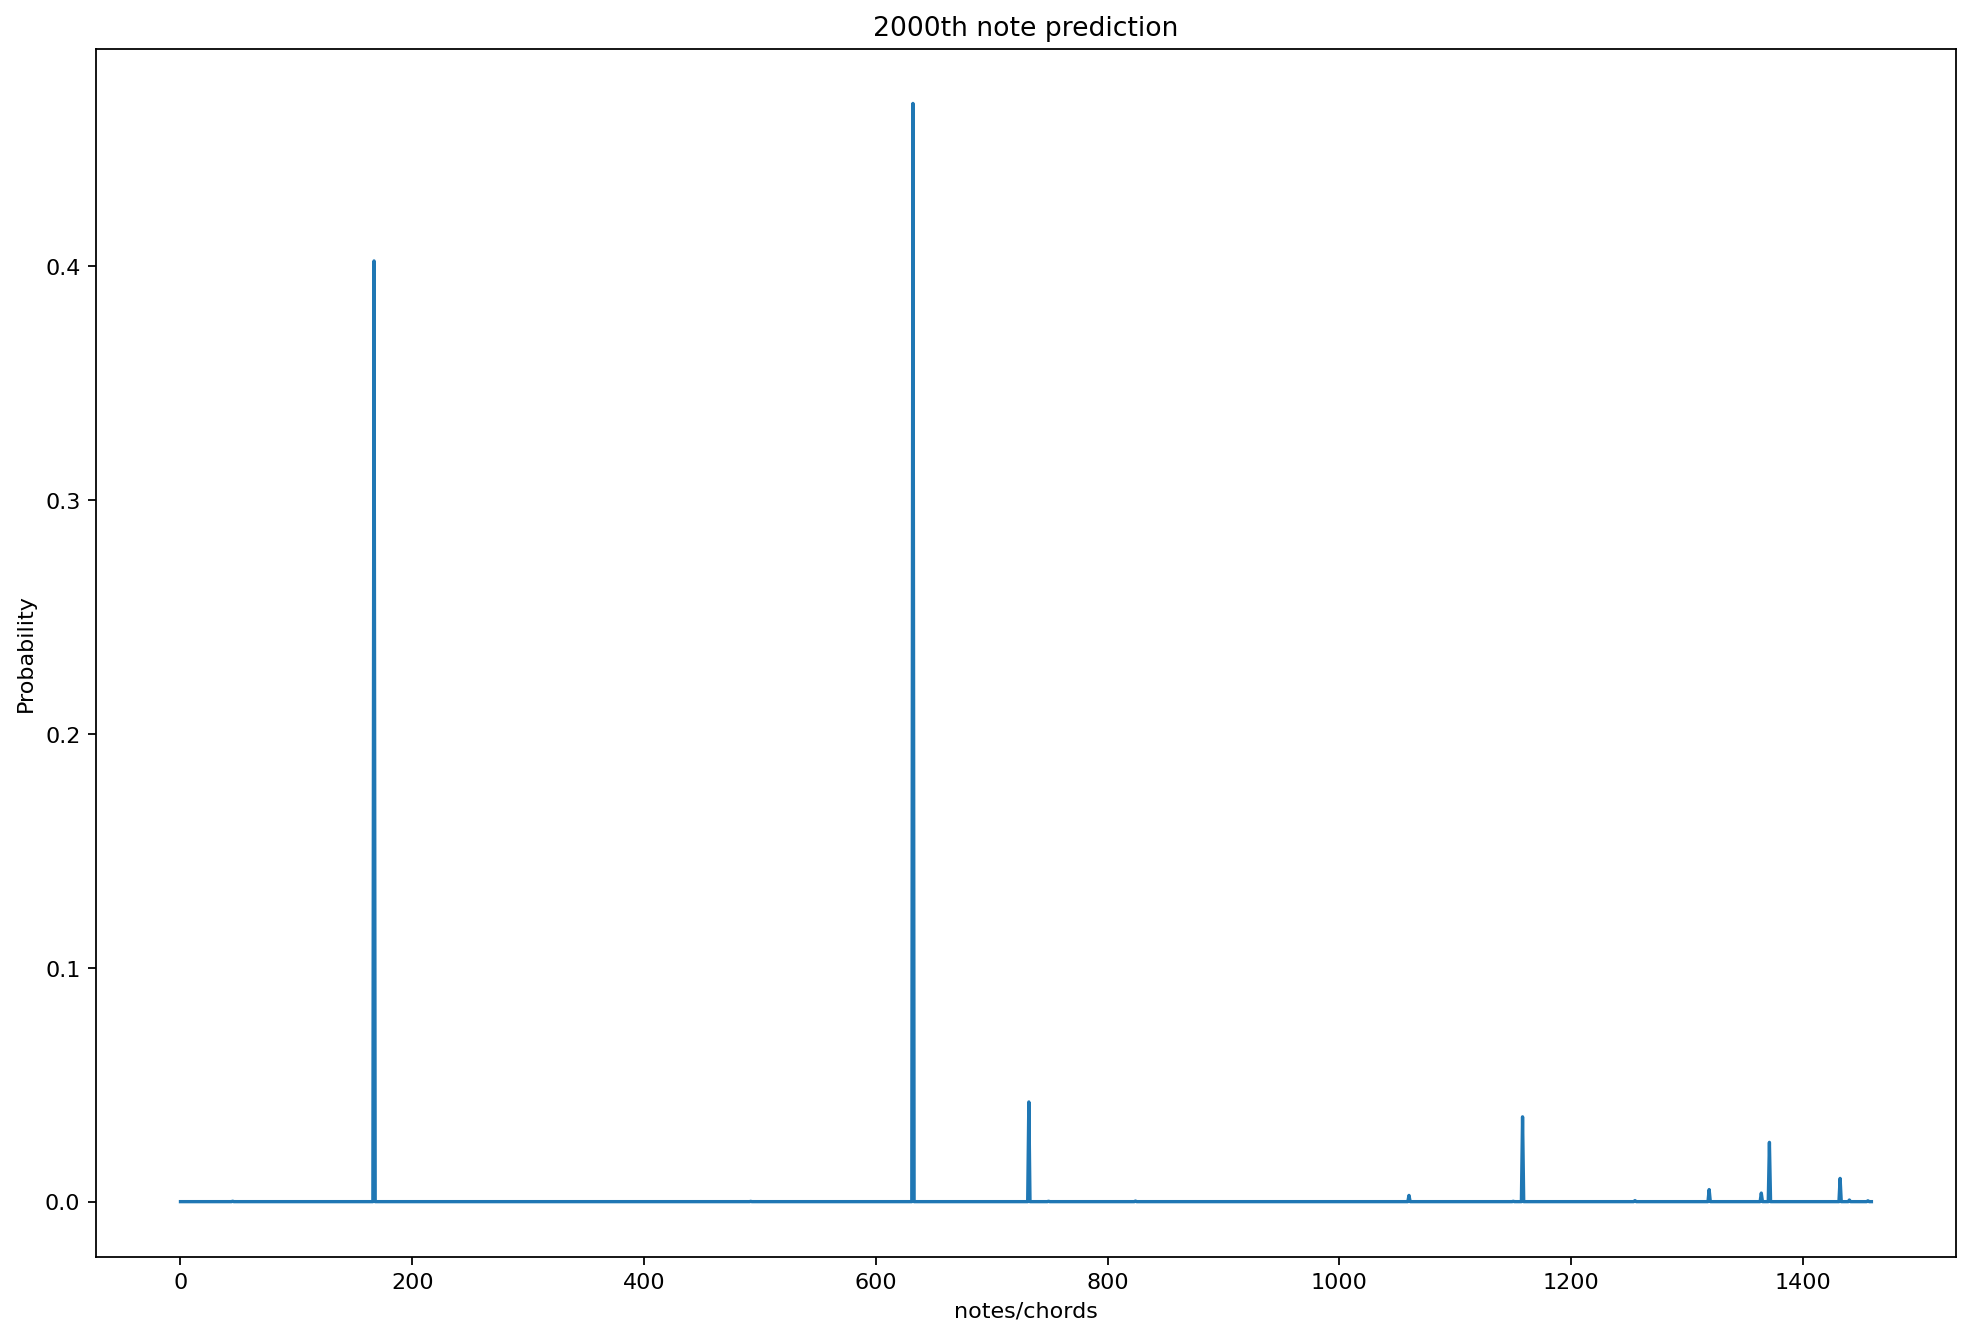

In [ ]:
figure(figsize=(15, 10), dpi=80)

plt.plot(probabilities[1950]) 
plt.ylabel('Probability')
plt.xlabel('notes/chords')
plt.title("2000th note prediction")

Text(0.5, 1.0, '2499th note prediction')

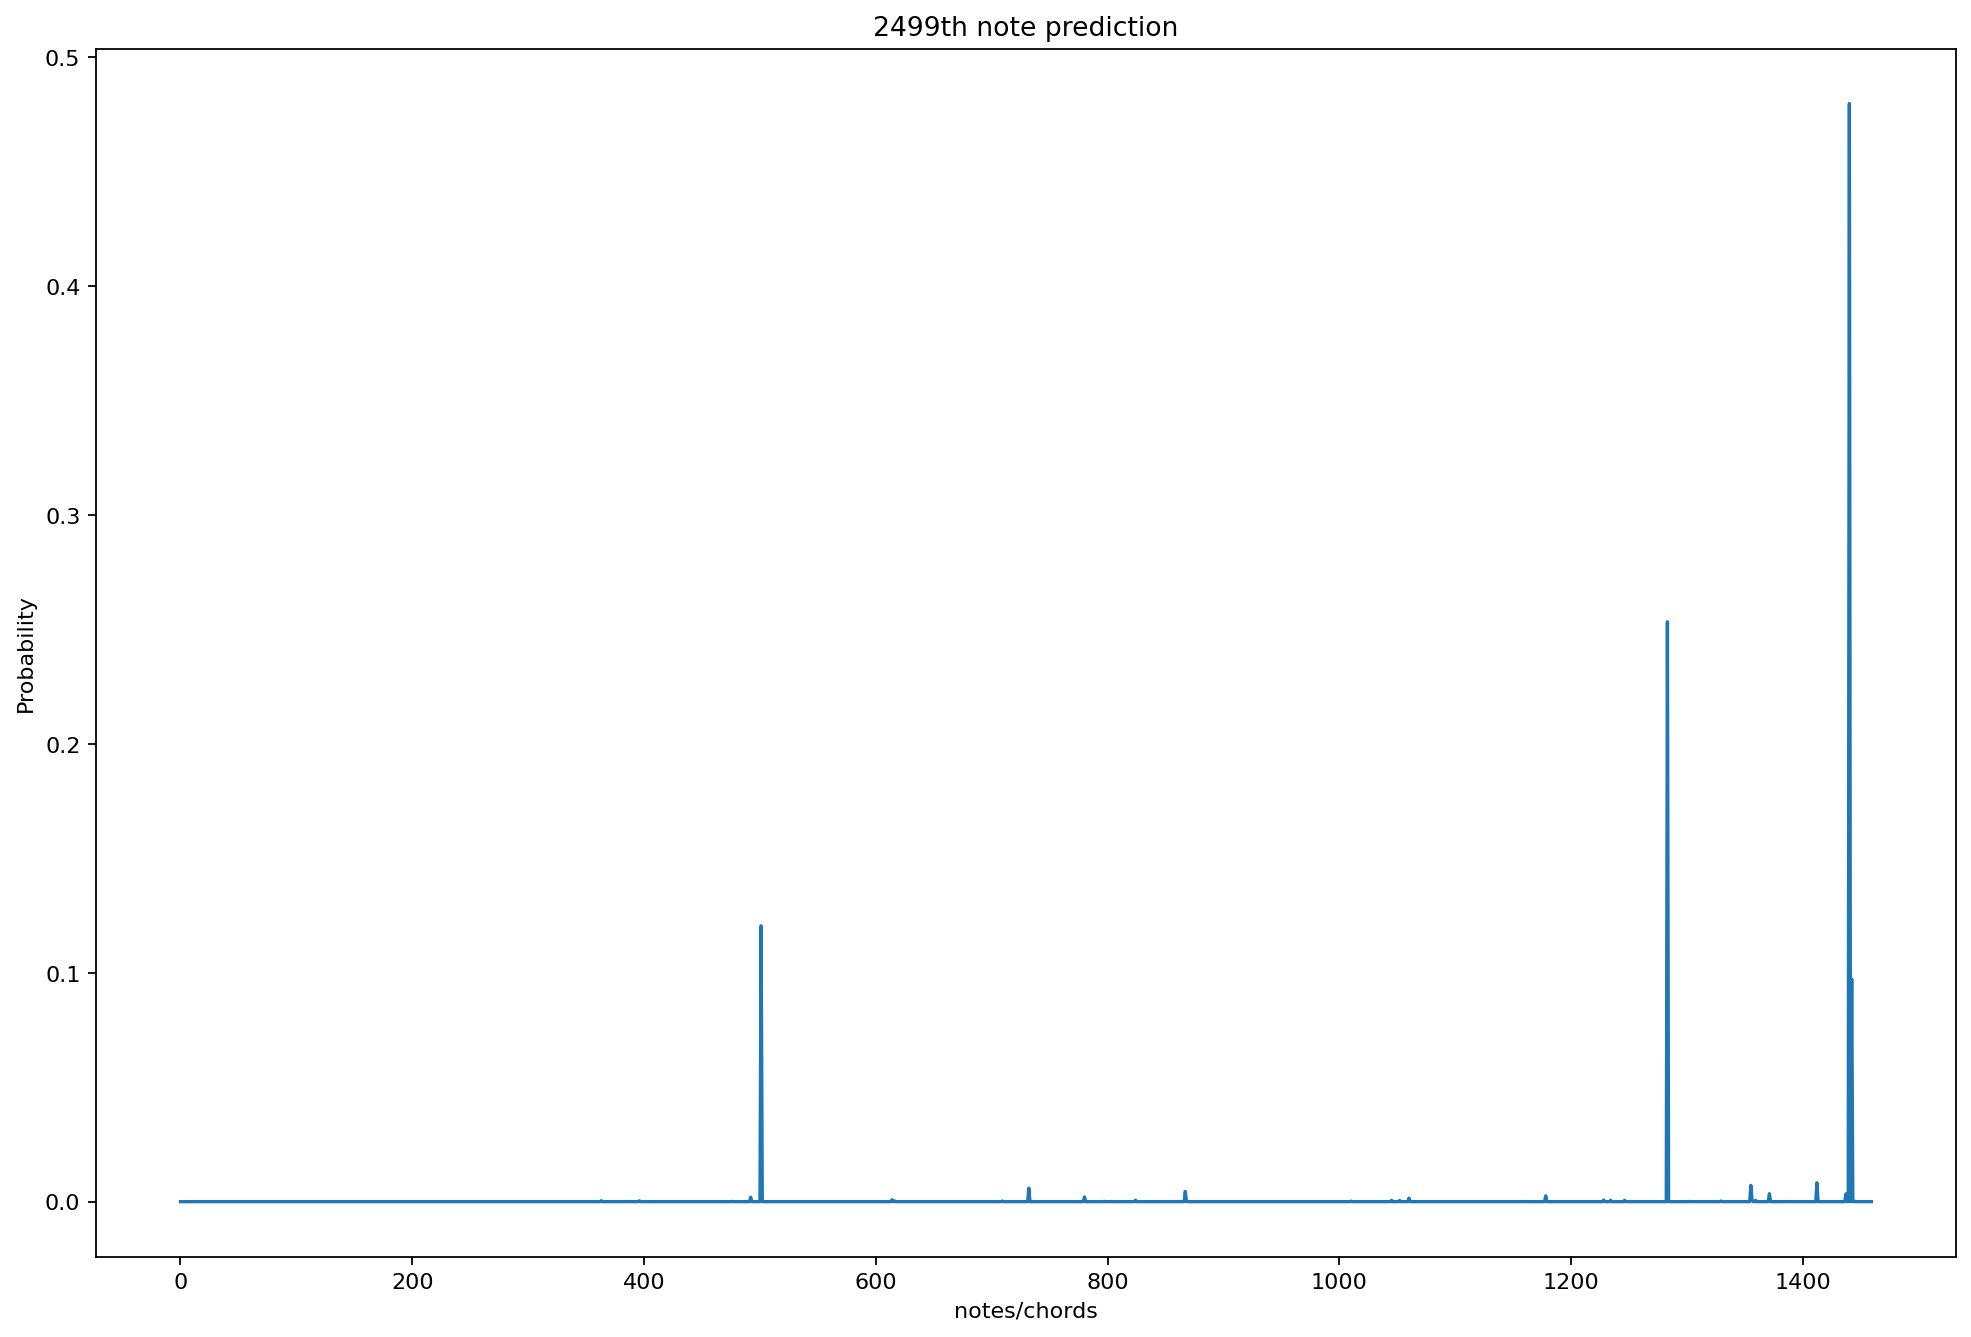

In [ ]:
figure(figsize=(15, 10), dpi=80)

plt.plot(probabilities[2499]) 
plt.ylabel('Probability')
plt.xlabel('notes/chords')
plt.title("2499th note prediction")

Save generated sequence to ,midi/.mid file

In [ ]:
from music21 import converter, instrument, note, chord, stream, tempo

mm1 = tempo.MetronomeMark(number=60)
lista = [mm1]


'''
notes2 = numpy.concatenate((notes['pitch'][starting_point:starting_point+sequence_length].to_numpy(), predicted_notes), axis=0)
predicted_duration2 = numpy.concatenate((notes['duration'][starting_point:starting_point+sequence_length].to_numpy(), predicted_duration), axis=0)
predicted_offset2 = numpy.concatenate((notes['offset'][starting_point:starting_point+sequence_length].to_numpy(), predicted_offset), axis=0)

'''
notes2 = predicted_notes
predicted_duration2 = predicted_duration
predicted_offset2 = predicted_offset


prev_offset = 0

for i in numpy.arange(len(notes2)):
    n = notes2[i]
    print(i," -->",n)
    if '.'not in n:
        print("  nota")
        m = note.Note(n, quarterLength=float(predicted_duration2[i]))
        m.offset = prev_offset + predicted_offset2[i]
        m.volume.velocity = numpy.random.randint(50,100,1)[0]
        prev_offset = prev_offset + predicted_offset2[i]
        lista.append(m)
    else:
        print("  accordo")
        m = chord.Chord((n).split('.'),quarterLength=float(predicted_duration2[i]))
        m.offset = prev_offset + predicted_offset2[i]
        m.volume.velocity = numpy.random.randint(60,100,1)[0]
        prev_offset = prev_offset + predicted_offset2[i]
        lista.append(m)


s = stream.Stream(lista)

s.write('mid',fp='Chopin_AI_composition_No_13.midi.mid')

0  --> F#3
  nota
1  --> A#3
  nota
2  --> F#3
  nota
3  --> A#5
  nota
4  --> F#5
  nota
5  --> G#5
  nota
6  --> G3
  nota
7  --> A#3
  nota
8  --> C#5
  nota
9  --> E2
  nota
10  --> F#2
  nota
11  --> A#4
  nota
12  --> F#4
  nota
13  --> A#4
  nota
14  --> D#5
  nota
15  --> A#4
  nota
16  --> D5
  nota
17  --> B4
  nota
18  --> A#4
  nota
19  --> D5
  nota
20  --> B4
  nota
21  --> G#4
  nota
22  --> A#4
  nota
23  --> G4
  nota
24  --> A#4
  nota
25  --> C#2
  nota
26  --> C#4.E3
  accordo
27  --> C#4
  nota
28  --> C#4
  nota
29  --> C#4
  nota
30  --> C#4
  nota
31  --> C#4
  nota
32  --> G#4
  nota
33  --> G#5
  nota
34  --> C#4.G#3
  accordo
35  --> B3
  nota
36  --> B3
  nota
37  --> F5
  nota
38  --> F#4
  nota
39  --> A#3
  nota
40  --> D4
  nota
41  --> C#4.E3
  accordo
42  --> C#4.E3
  accordo
43  --> B3
  nota
44  --> G#5
  nota
45  --> C#4
  nota
46  --> C#4
  nota
47  --> A#3
  nota
48  --> G4
  nota
49  --> F#3
  nota
50  --> F#3
  nota
51  --> A#3
  nota
52  --> G4

'test1.mid'